<a href="https://colab.research.google.com/github/maheshyadav007/research/blob/main/NPK_circle_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install torchviz

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from sklearn.model_selection import train_test_split 
import seaborn as sns
#from torchviz import make_dot
from google.colab import files
from scipy.linalg import eigh

%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"

**Input Generation**

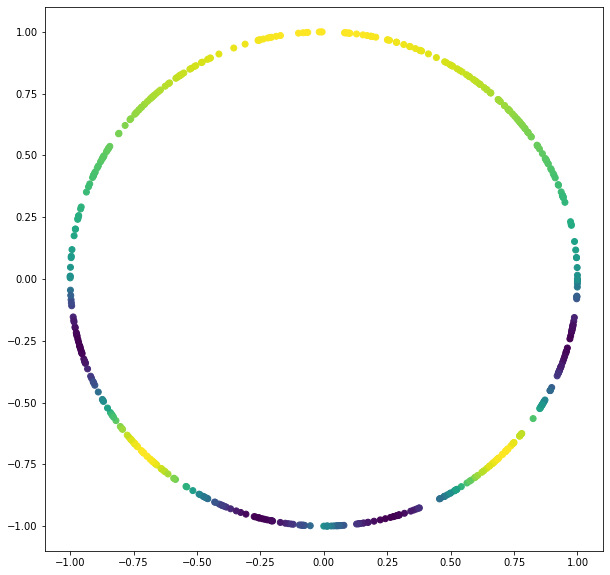

In [ ]:
class CustomDataset(Dataset):
      def __init__(self, X, Y):
          self.size = len(Y)
          self.x = torch.tensor(X)
          self.y = torch.tensor(Y)

      def __len__(self):
          return (self.size)

      def __getitem__(self, idx):
          #print(self.x[idx].shape,self.y[idx].shape )
          return self.x[idx].float(), self.y[idx].float()


n_data_points = 500
x1 = np.random.uniform(low = -1, high = 1, size = (n_data_points,1))
x2 = np.random.uniform(low = -1, high = 1, size = (n_data_points,1))

X = np.concatenate((x1, x2), axis = 1)
X = X/np.sqrt(x1**2 + x2**2)

Y = [ [np.sin(np.arcsin(i))] if i > 0 else [np.sin(6*np.arcsin(i))]  for i in X[:,1] ]
Y = np.array(Y)

n_data = len(Y)

plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], c = Y)
#plt.savefig("Input Data")



#sorted_arg = np.argsort(X[:, 0])
sorted_arg = np.argsort(np.arctan2(X[:,1],X[:,0])*180/np.pi)
X_sorted = X[sorted_arg]
Y_sorted = Y[sorted_arg]

batch_size = len(Y)
dataloader = DataLoader(CustomDataset(X_sorted, Y_sorted), batch_size = batch_size, shuffle = False)


batch_size = 32
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, shuffle = True)

train_dataloader = DataLoader(CustomDataset(X_train, y_train), batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(CustomDataset(X_test, y_test), batch_size = batch_size, shuffle = True)

In [ ]:

# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return idx

# temp = np.array(np.sort(np.arctan2(X[:,1],X[:,0])*180/np.pi), dtype = int)
# value1 = -100
# x1_idx = find_nearest(temp, value1)
# x2_idx = find_nearest(temp, value1+10)

# value2 = 70
# x3_idx = find_nearest(temp, value1)
# x4_idx = find_nearest(temp, value1+10)

**MLP**

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0
    for batch, (x,y) in enumerate(dataloader):
        X, y = x.to(device), y.to(device)
        pred, _ = model(X.float())
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch%16 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} Batch:{batch} [{current:>5d}/{size:>5d}]")
    return pred

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred , out = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return pred, out, test_loss

In [ ]:
class NeuralNet(nn.Module):
  def __init__(self, n_hidden_layers, n_neurons, architecture_type):
        super(NeuralNet, self).__init__()
        
        # self.n_neurons = n_neurons
        # self.fc1 = nn.Linear(2, self.n_neurons)
        # self.fc2 = nn.Linear(self.n_neurons, self.n_neurons)
        # self.fc3 = nn.Linear(self.n_neurons, self.n_neurons)
        # self.fc4 = nn.Linear(self.n_neurons, self.n_neurons)
        # self.fc5 = nn.Linear(self.n_neurons, self.n_neurons)
        # self.fc6 = nn.Linear(self.n_neurons, 1)


        self.architecture_type = architecture_type
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons

        
        self.layers = nn.ModuleList([nn.Linear(2,  self.n_neurons, bias = True).to(device)])
        #self.dlgn_Sf_layers = nn.ModuleList([nn.Linear(2,  self.n_neurons).to(device)])
        
        for i in range(self.n_hidden_layers-1):
          self.layers.append(nn.Linear( self.n_neurons,  self.n_neurons).to(device))
        
        
        
        self.layers.append(nn.Linear( self.n_neurons, 1, bias = True).to(device))



  def forward(self, x, batch = None):
        # x = self.fc1(x)
        # o1 = torch.relu(x)
        # x = self.fc2(o1)
        # o2 = torch.relu(x)
        # x = self.fc3(o2)
        # o3 = torch.relu(x)
        # x = self.fc4(o3)
        # o4 = torch.relu(x)
        # x = self.fc5(o4)
        # o5 = torch.relu(x)
        # x = self.fc6(o5)

        hidden_layer_outputs = []
      
        
        for i in range(len(self.layers)-1):
          x = self.layers[i](x)
          out = torch.relu(x)
          hidden_layer_outputs.append(out)
          x = out
        x = self.layers[-1](x)
    
        return x, hidden_layer_outputs
        

In [ ]:
# model_architecture_type = "MLP"
# n_neurons = 32
# n_hidden_layers = 4
# model_info = {"model_architecture_type" : model_architecture_type,"n_hidden_layers":n_hidden_layers, "n_neurons" : n_neurons}


# mlp_model = NeuralNet(n_neurons).to(device)
# loss_fn = nn.MSELoss()
# optimizer = torch.optim.Adam(mlp_model.parameters(),lr = 3e-3)  

# weights_all_epochs = []
# losses = []
# model_learning_status = "UnLearned"

In [ ]:
# epochs = 300
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     #get_layer_weights()

#     pred = train(train_dataloader,mlp_model, loss_fn, optimizer)
#     _,_, loss = test(test_dataloader,mlp_model, loss_fn)
#     losses.append(loss)
# print("Done!")
# model_learning_status = "Learned"

**Visualizing Kernels for MLP**

In [ ]:
def get_kernels(hidden_layer_outputs):
  n_hidden_layer = len(hidden_layer_outputs)
  for i in range(n_hidden_layer):
    hidden_layer_outputs[i] = np.sign(hidden_layer_outputs[i].detach().to("cpu"))

  hidden_layer_kernels = []
  for i in range(n_hidden_layer):
    hidden_layer_kernels.append(np.matmul(hidden_layer_outputs[i].numpy(),hidden_layer_outputs[i].numpy().T))

  lambda_matrix = hidden_layer_kernels[0]
  for i in range(1,n_hidden_layer):
    lambda_matrix = np.multiply(lambda_matrix, hidden_layer_kernels[i])
  
  kernels = hidden_layer_kernels + [lambda_matrix]
  
  return kernels

In [ ]:
def plot_heatmap(K, model_info):
  for i in range(len(K)):
    # plt.figure(figsize = (15,15))
    # ax = sns.heatmap(K[i][0:500:5,0:500:5], linewidth=.2)
    plt.figure(figsize = (10,10))
    ax = sns.heatmap(K[i][[x1_idx, x2_idx, x3_idx, x4_idx]][:,[x1_idx, x2_idx, x3_idx, x4_idx]], linewidth=.2)
    model_title = model_info["model_architecture_type"] +'(' + 'n_h_l = '+ str(model_info["n_hidden_layers"])+ ', n_n = '+ str(model_info["n_neurons"])+', ' +model_learning_status+', K'+str(i+1) +', ' +'Run=' + str(model_info["Run"])+", Y'KY_n = "+  model_info["Y'KY"][i] +')'
    if i < len(K)-1:
      plt.title(model_title)
      plt.savefig(model_title + ".png", format = "png")
      #files.download(model_title+".png") 
    else:
      model_title = model_info["model_architecture_type"] +'('+ 'n_h_l = '+ str(model_info["n_hidden_layers"])+ ', n_n = '+ str(model_info["n_neurons"]) +', ' + model_learning_status+', K'+', ' + 'Run=' + str(model_info["Run"])+ ", Y'KY_n = "+ model_info["Y'KY"][i] +')'
      plt.title(model_title)
      plt.savefig(model_title+ ".png", format = "png")
      #files.download(model_title+".png") 
    plt.show()

In [ ]:
# prediction, hidden_layer_outputs,_ = test(dataloader,mlp_model, loss_fn)

# kernels = get_kernels(hidden_layer_outputs)
# kernels_over_5.append(kernels)

In [ ]:
# kernels_mean = np.mean(np.array(kernels_over_5), axis = 0)
# kernels_over_5 = []

Test Error: 
 Accuracy: 0.0%, Avg loss: 0.501291 



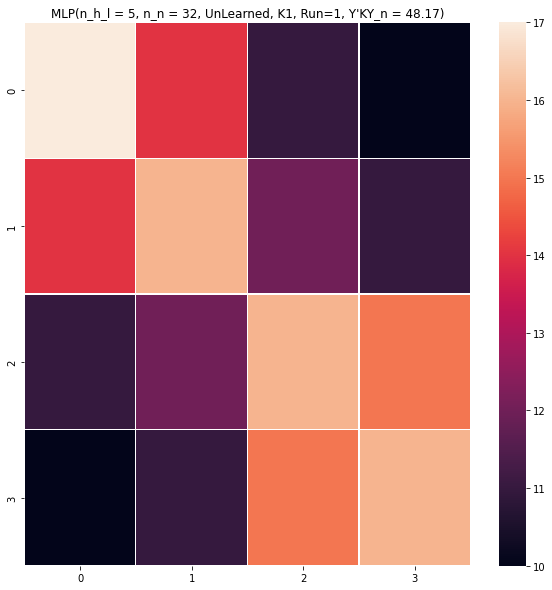

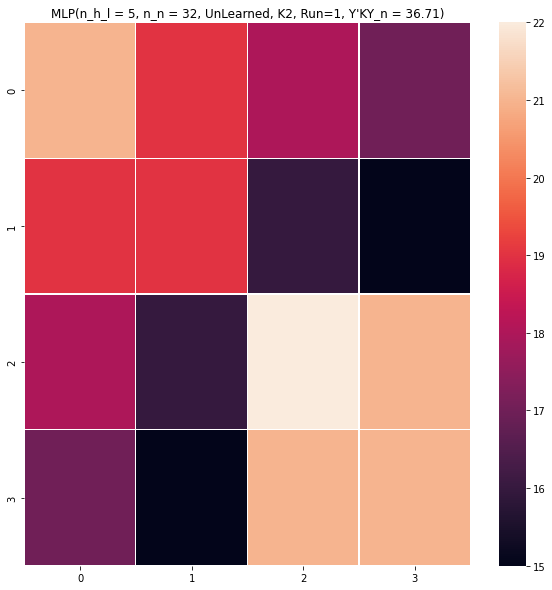

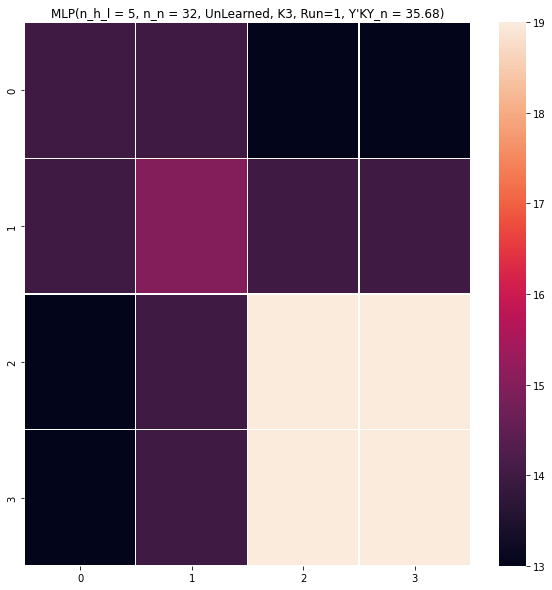

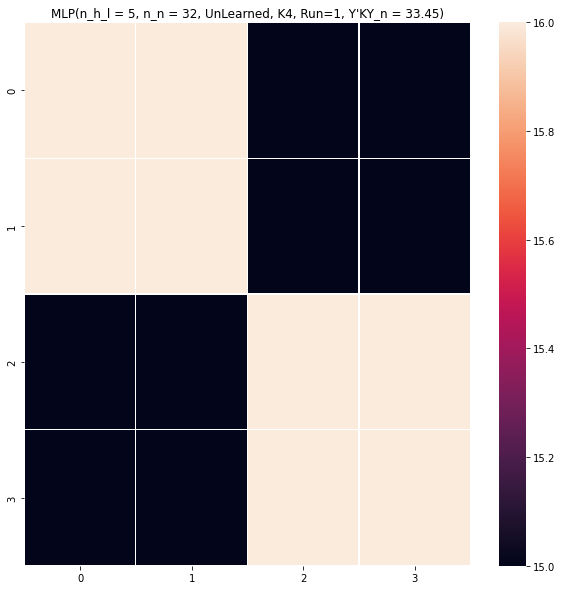

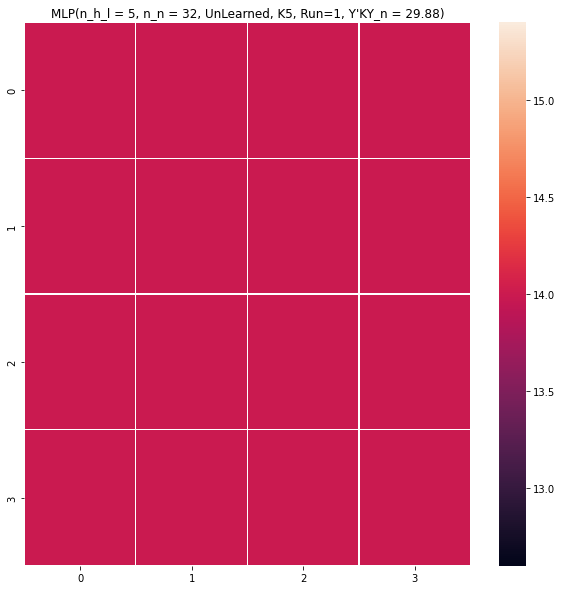

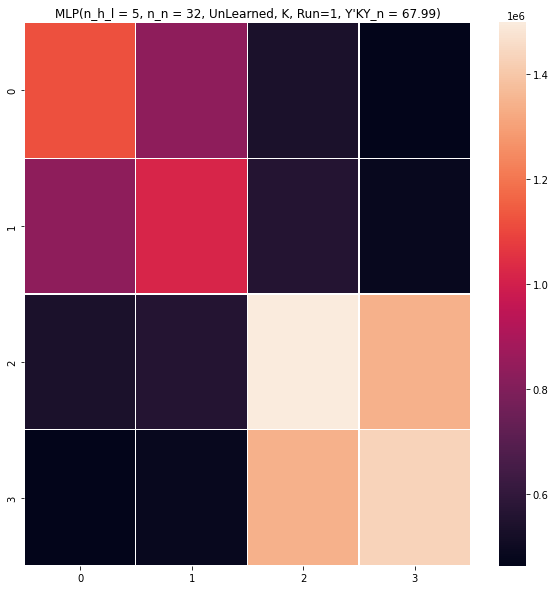

Epoch 1
-------------------------------
loss: 0.509508 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.411619 

Epoch 2
-------------------------------
loss: 0.357935 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.303214 

Epoch 3
-------------------------------
loss: 0.295777 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.274404 

Epoch 4
-------------------------------
loss: 0.279484 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.267378 

Epoch 5
-------------------------------
loss: 0.331004 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.267050 

Epoch 6
-------------------------------
loss: 0.178700 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.265836 

Epoch 7
-------------------------------
loss: 0.213311 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.264904 

Epoch 8
-------------------------------
loss: 0.198490 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0

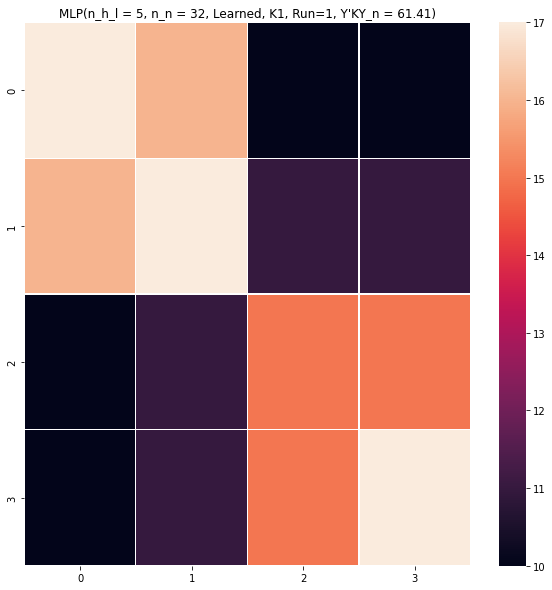

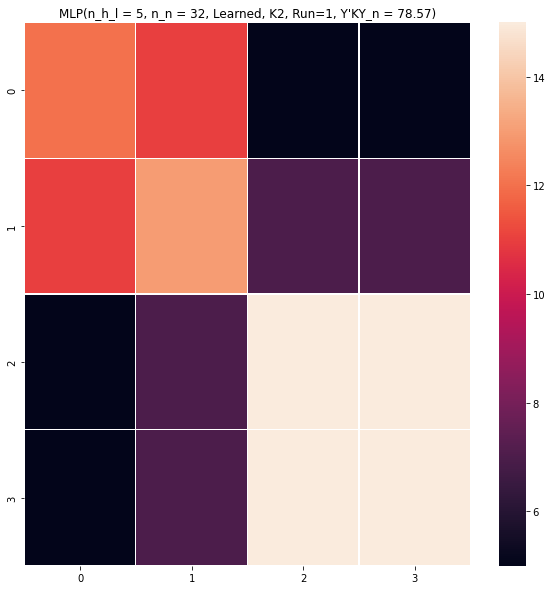

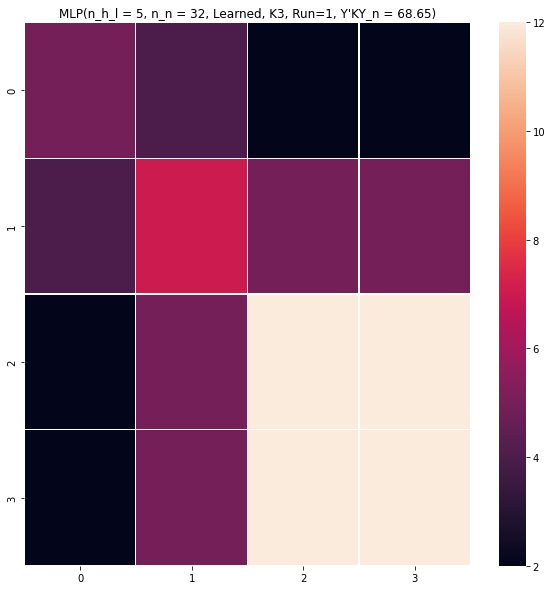

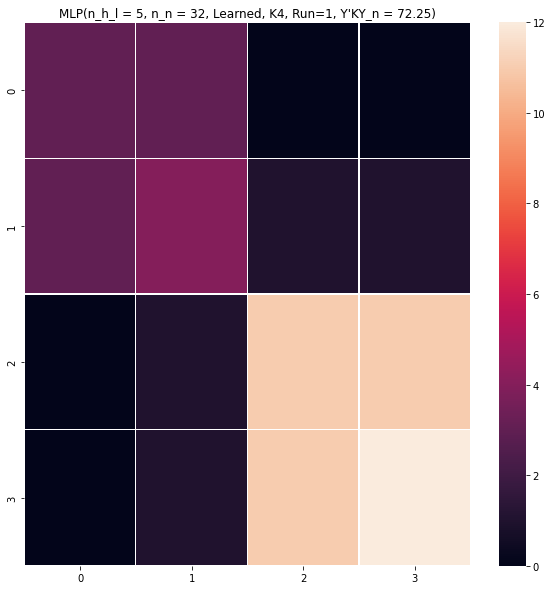

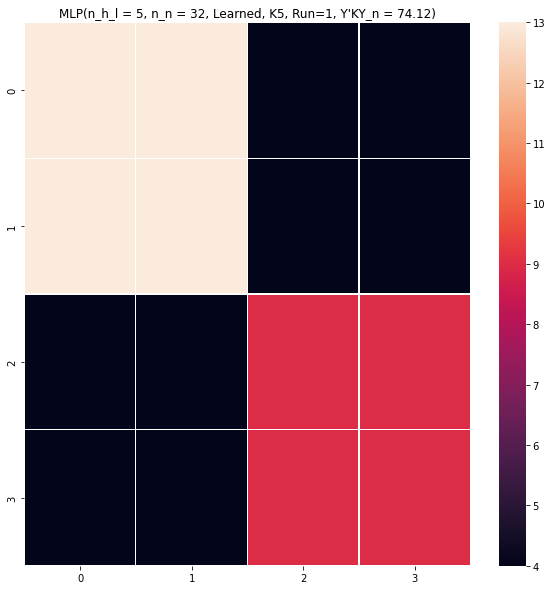

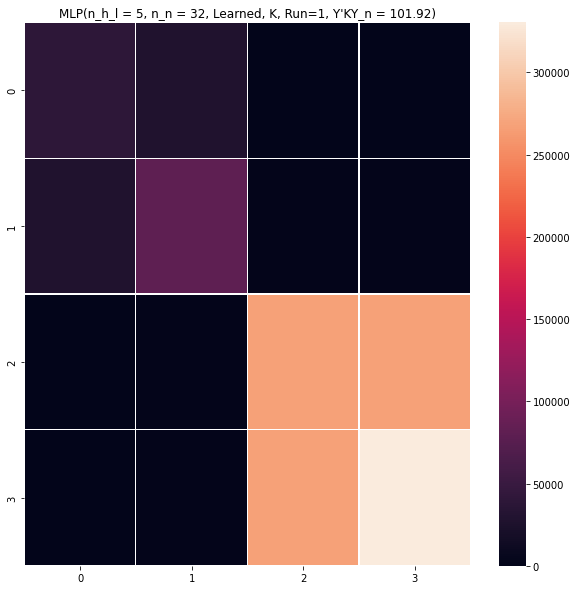

Test Error: 
 Accuracy: 0.0%, Avg loss: 0.580271 



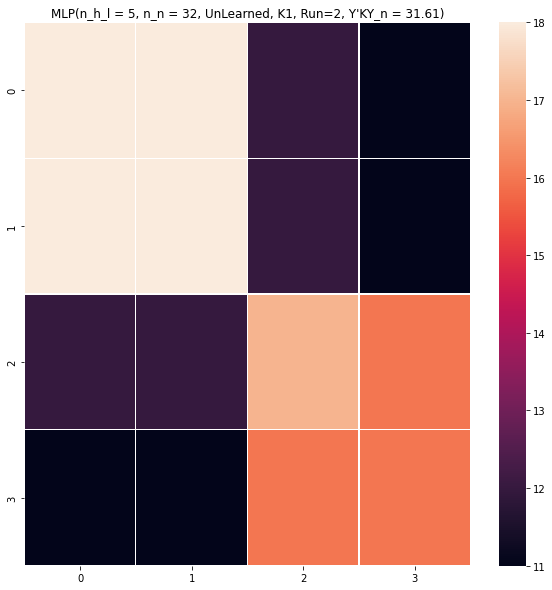

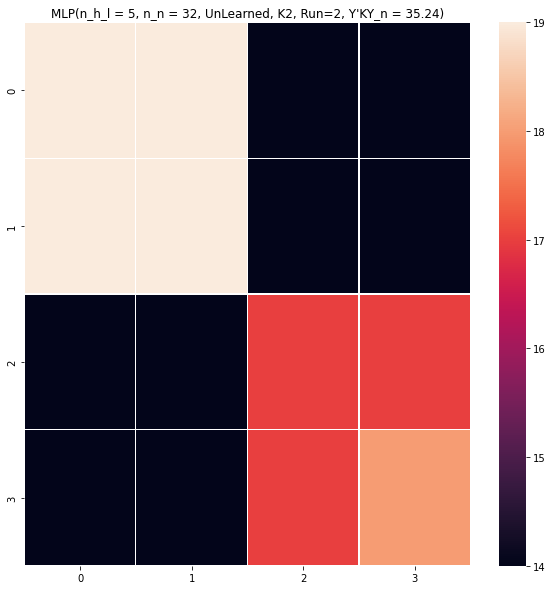

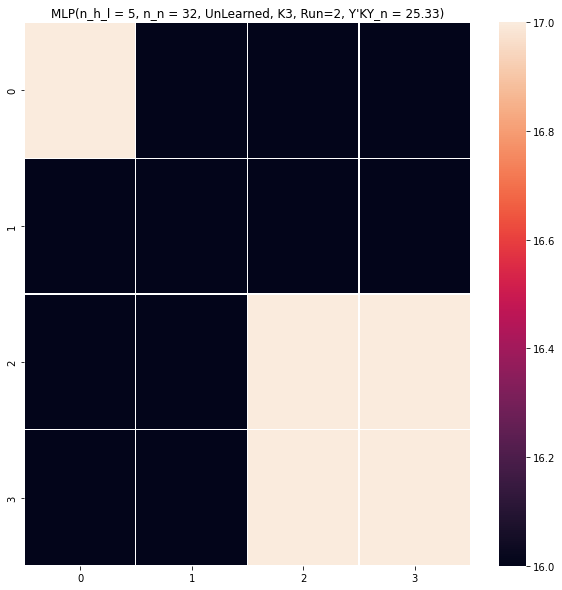

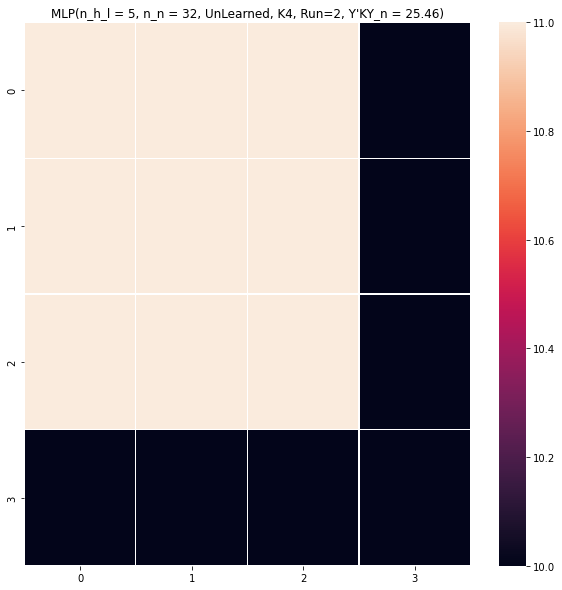

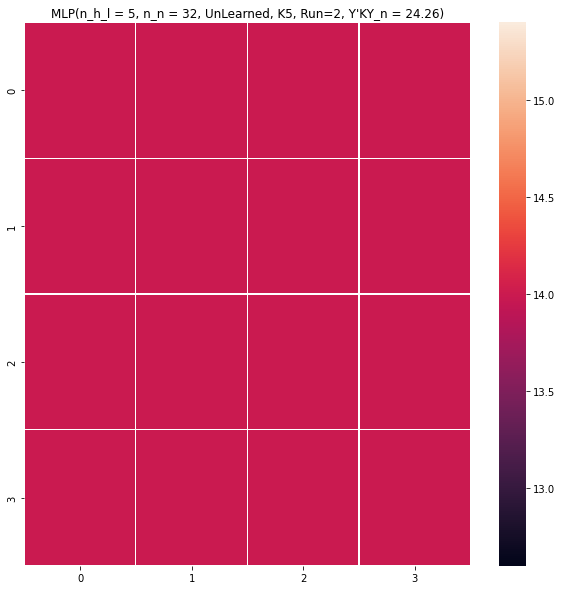

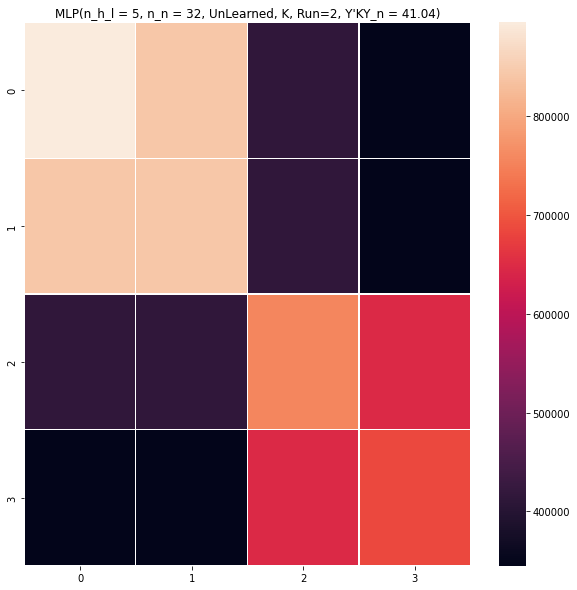

Epoch 1
-------------------------------
loss: 0.668186 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.396821 

Epoch 2
-------------------------------
loss: 0.433793 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.241618 

Epoch 3
-------------------------------
loss: 0.244024 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.229710 

Epoch 4
-------------------------------
loss: 0.217378 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.227350 

Epoch 5
-------------------------------
loss: 0.196727 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.221533 

Epoch 6
-------------------------------
loss: 0.324509 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.218478 

Epoch 7
-------------------------------
loss: 0.173244 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.217395 

Epoch 8
-------------------------------
loss: 0.172323 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0

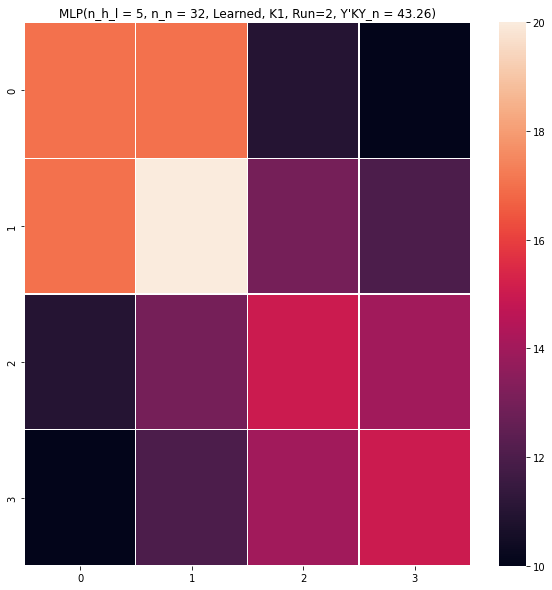

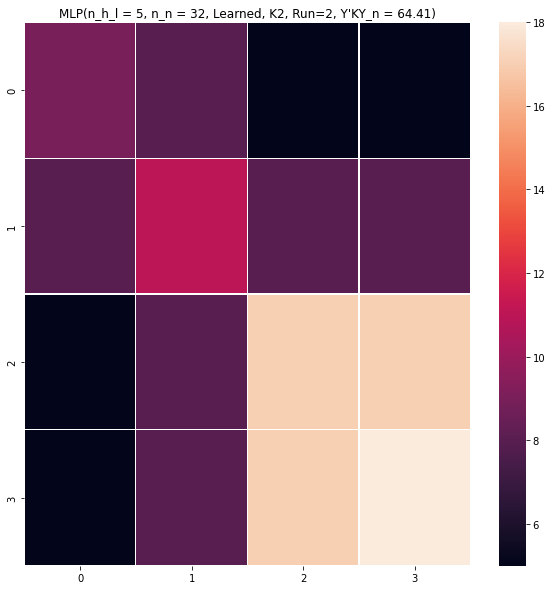

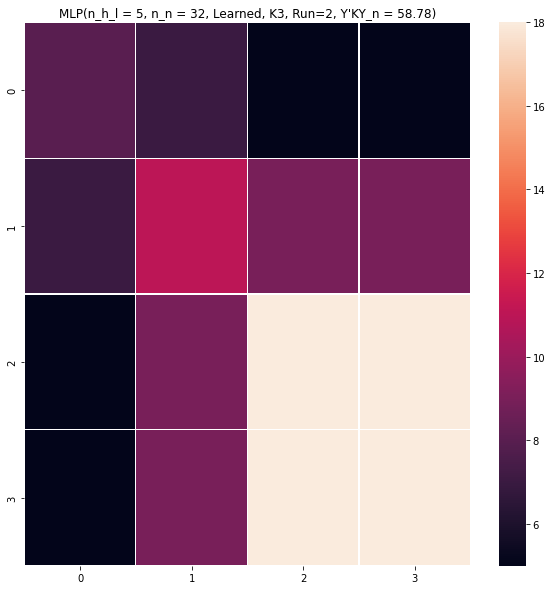

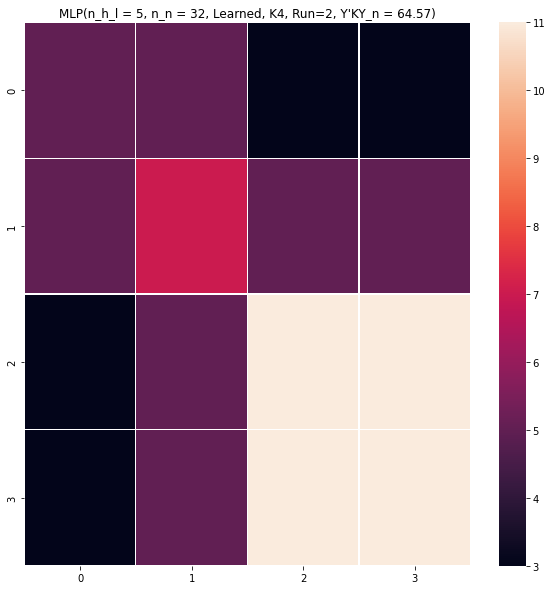

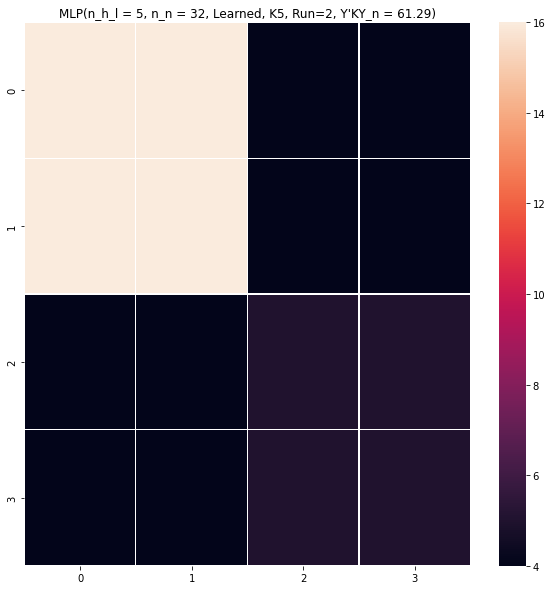

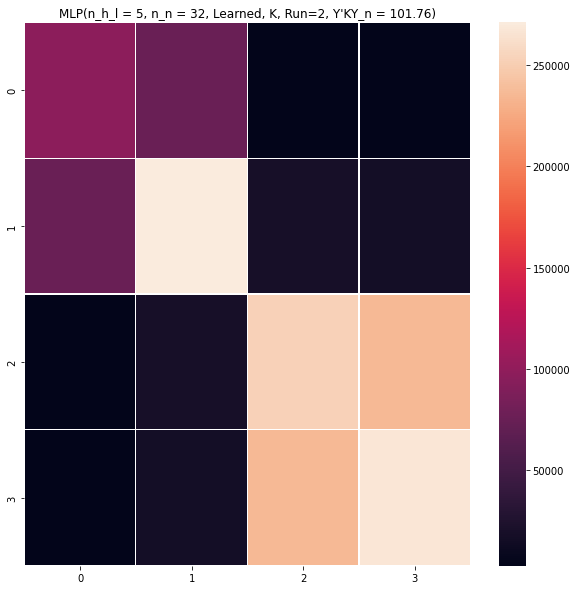

Test Error: 
 Accuracy: 0.0%, Avg loss: 0.494304 



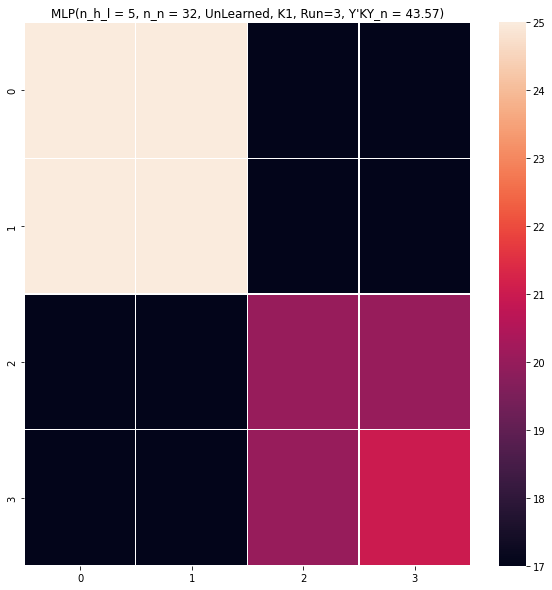

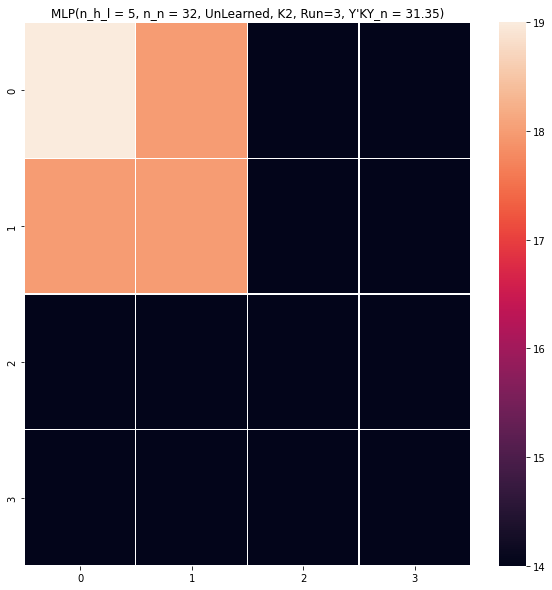

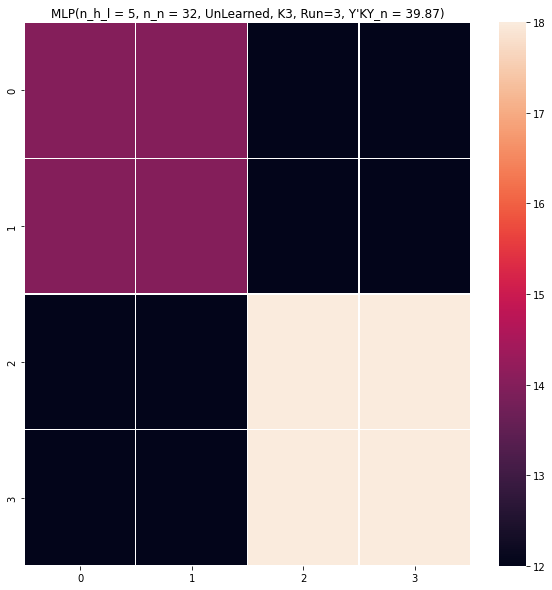

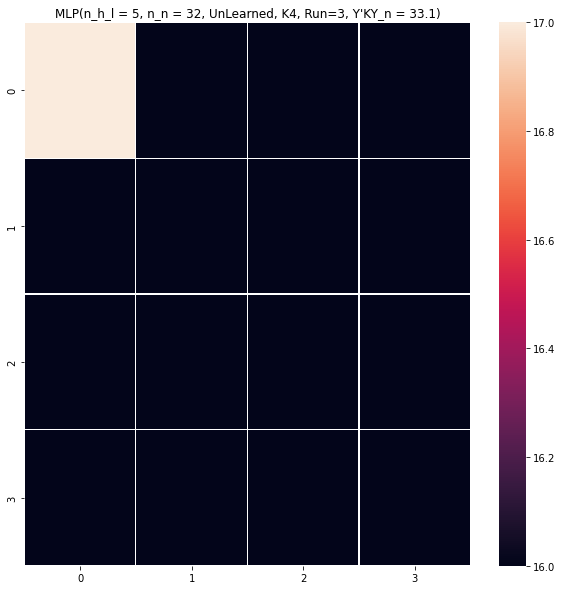

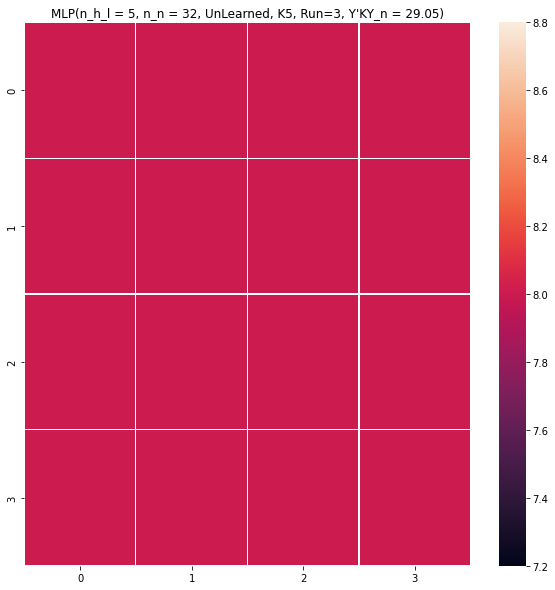

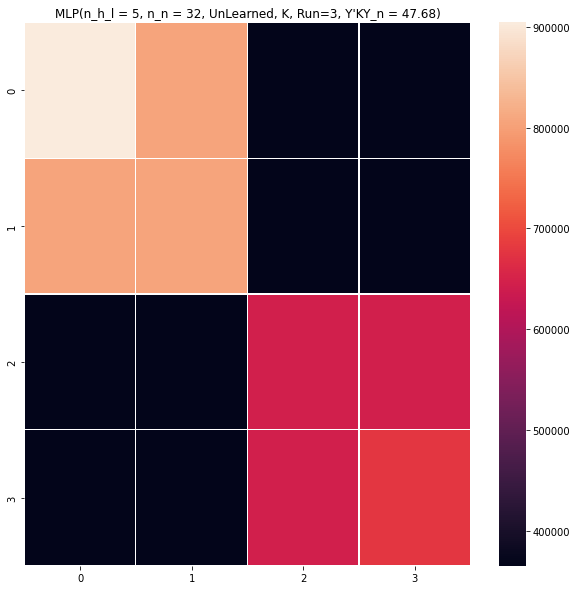

Epoch 1
-------------------------------
loss: 0.470204 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.377105 

Epoch 2
-------------------------------
loss: 0.369781 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.231324 

Epoch 3
-------------------------------
loss: 0.242041 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.208444 

Epoch 4
-------------------------------
loss: 0.189786 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.199636 

Epoch 5
-------------------------------
loss: 0.304913 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.202766 

Epoch 6
-------------------------------
loss: 0.198759 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.196876 

Epoch 7
-------------------------------
loss: 0.102885 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.197109 

Epoch 8
-------------------------------
loss: 0.179297 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0

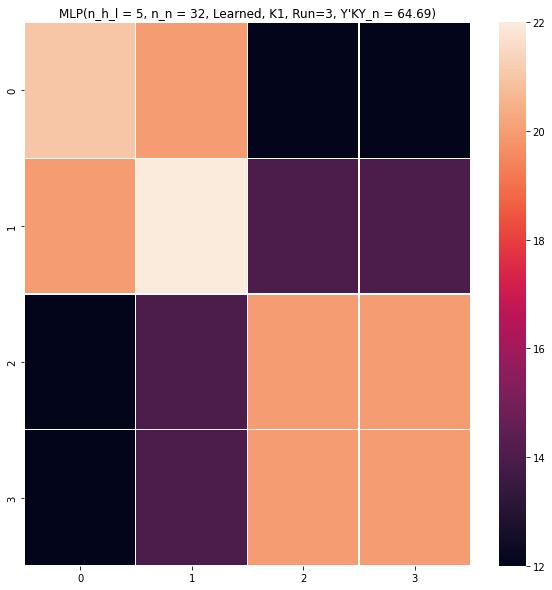

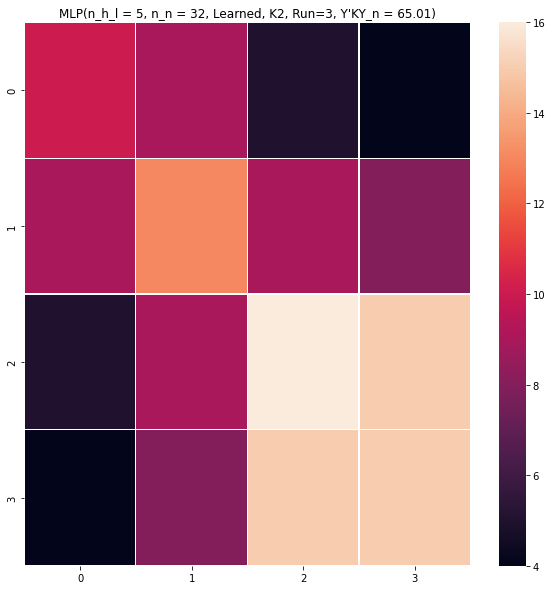

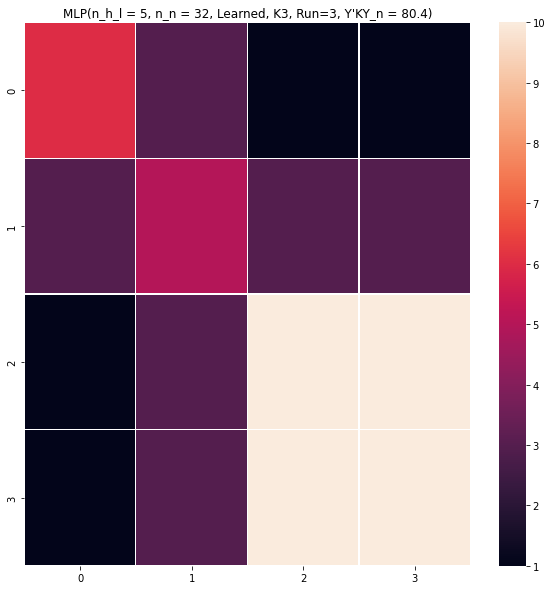

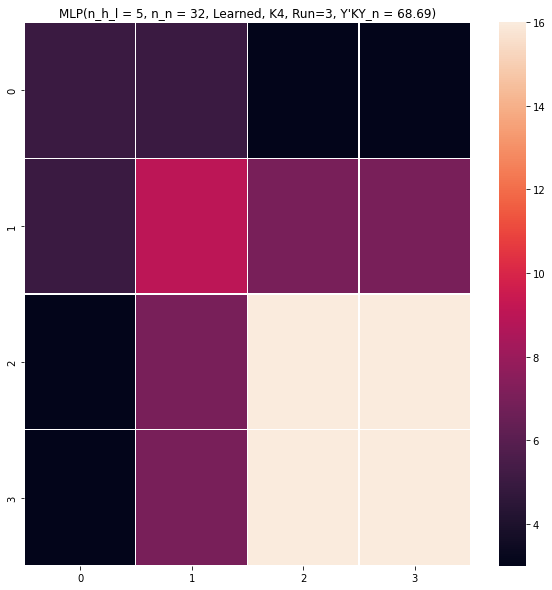

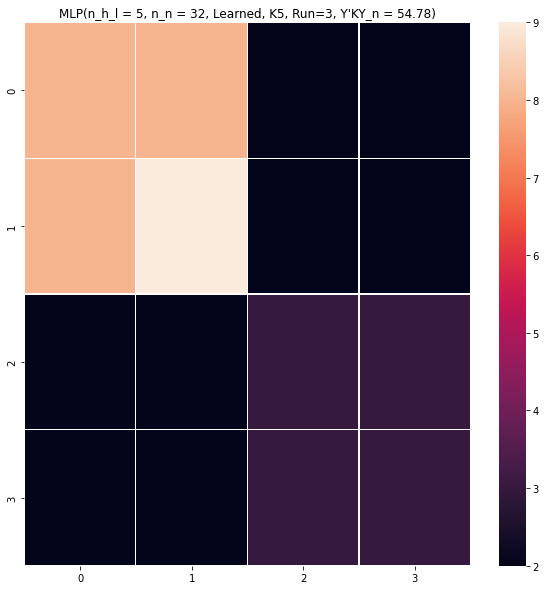

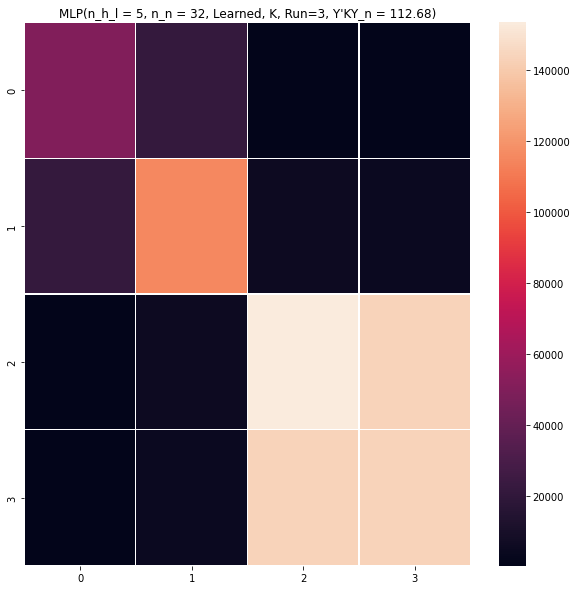

Test Error: 
 Accuracy: 0.0%, Avg loss: 0.498026 



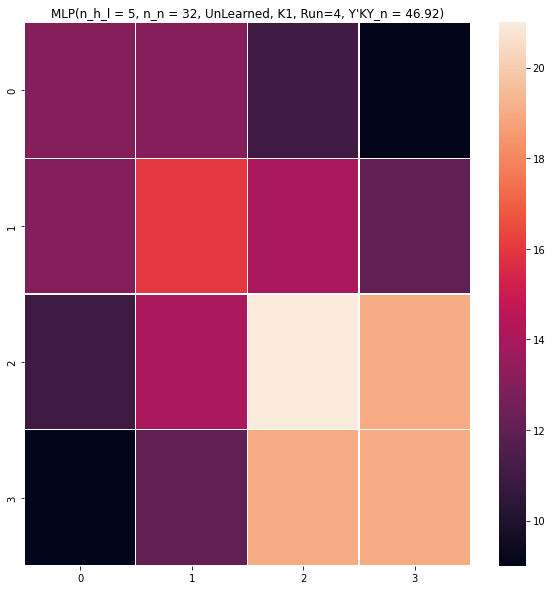

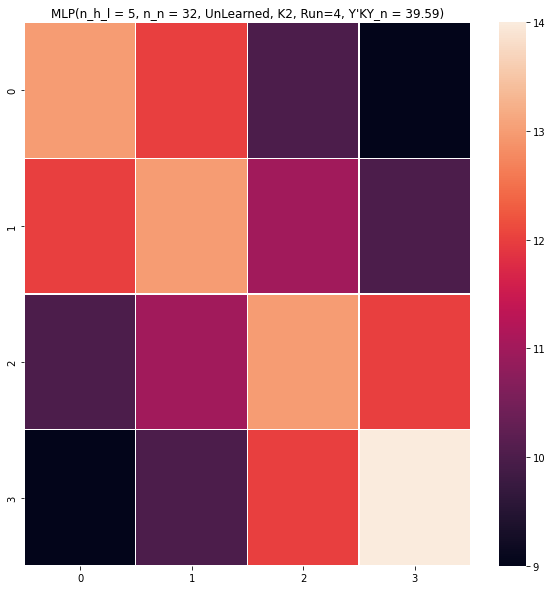

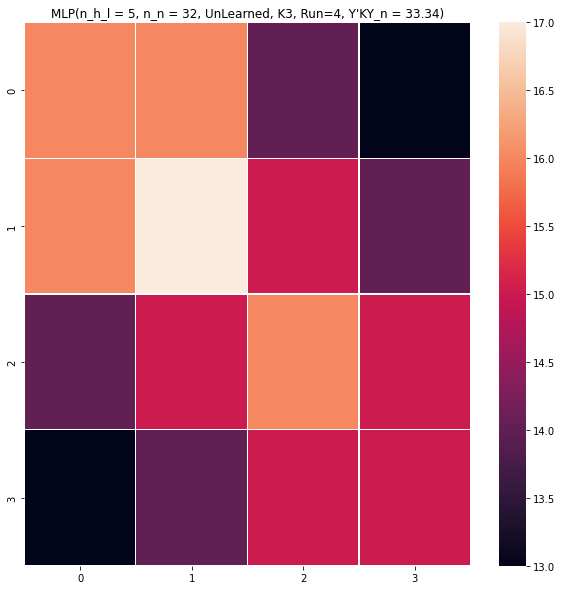

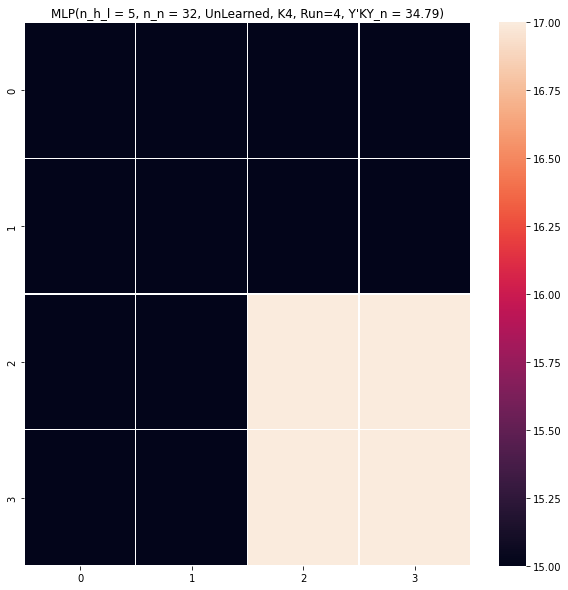

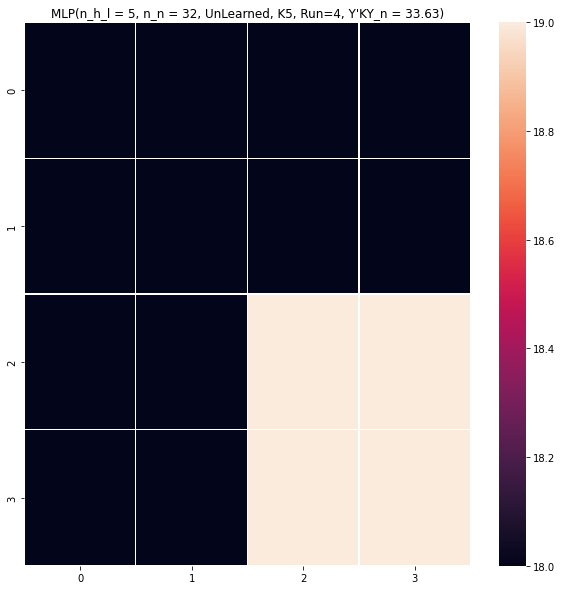

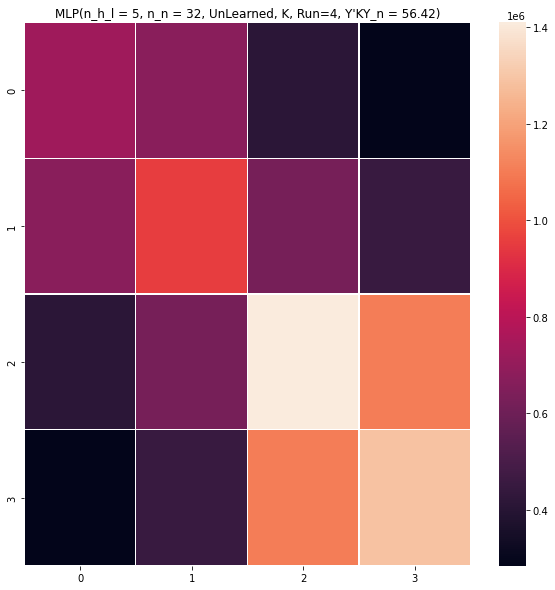

Epoch 1
-------------------------------
loss: 0.460197 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.372941 

Epoch 2
-------------------------------
loss: 0.360657 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.264062 

Epoch 3
-------------------------------
loss: 0.200475 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.256894 

Epoch 4
-------------------------------
loss: 0.189320 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.250508 

Epoch 5
-------------------------------
loss: 0.317957 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.248866 

Epoch 6
-------------------------------
loss: 0.323891 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.249659 

Epoch 7
-------------------------------
loss: 0.293857 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.247930 

Epoch 8
-------------------------------
loss: 0.314381 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0

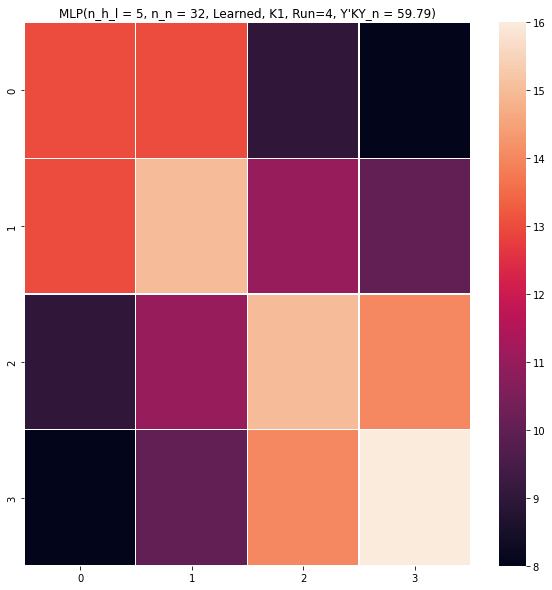

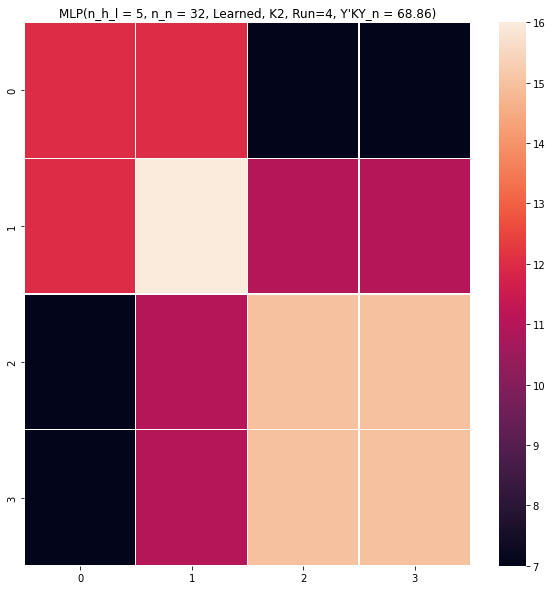

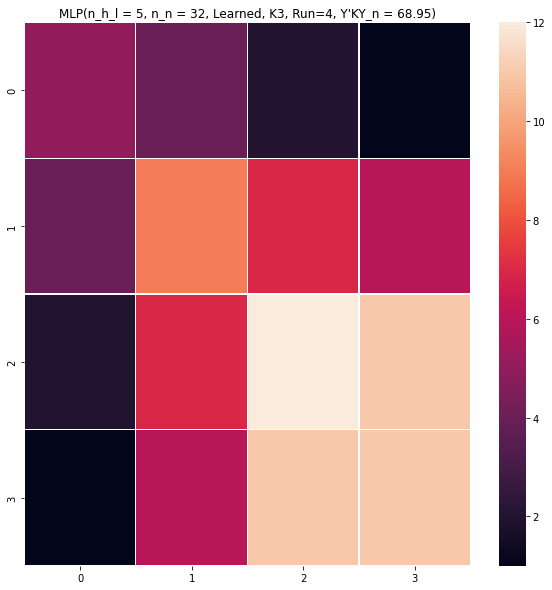

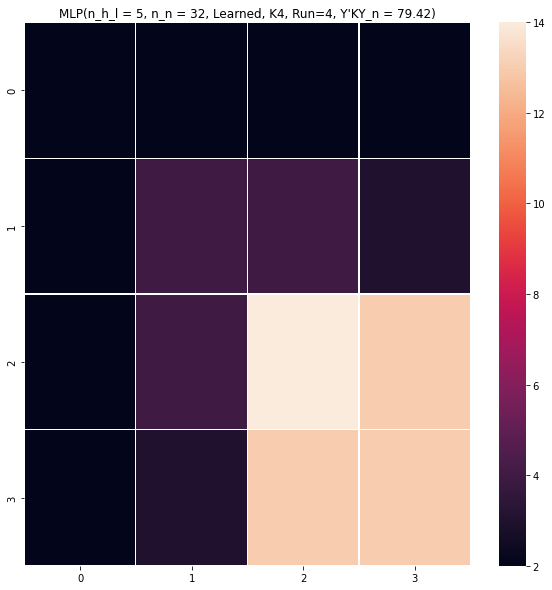

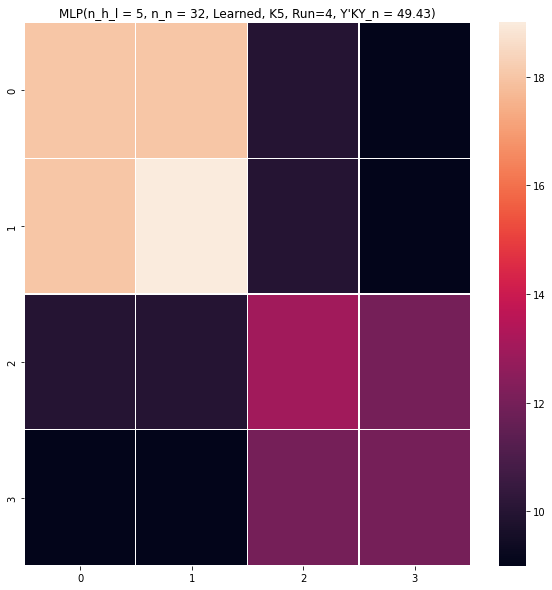

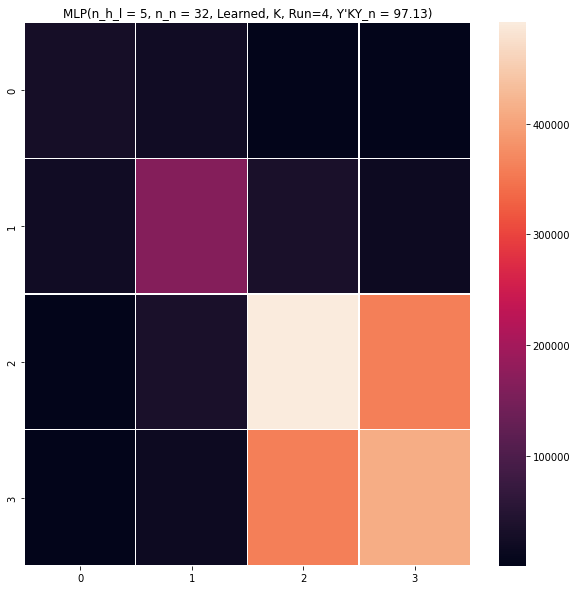

Test Error: 
 Accuracy: 0.0%, Avg loss: 0.562218 



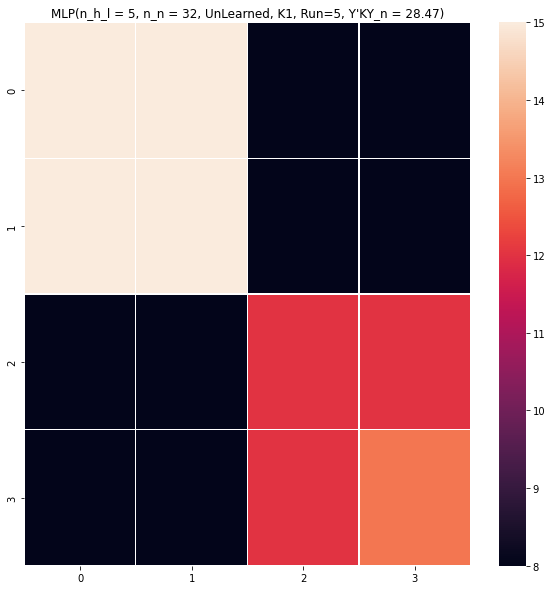

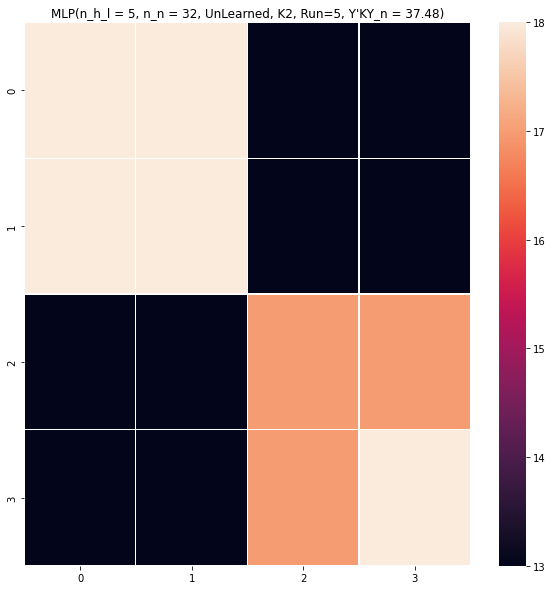

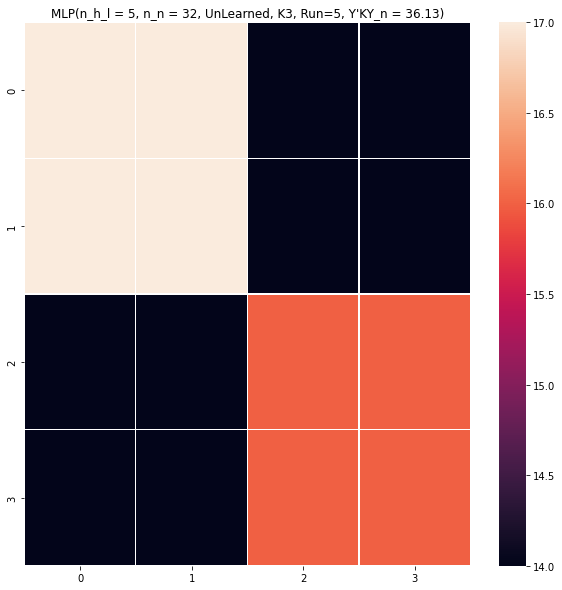

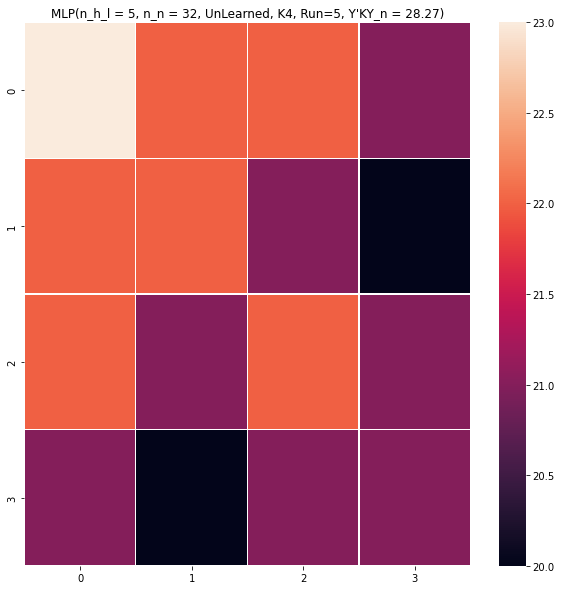

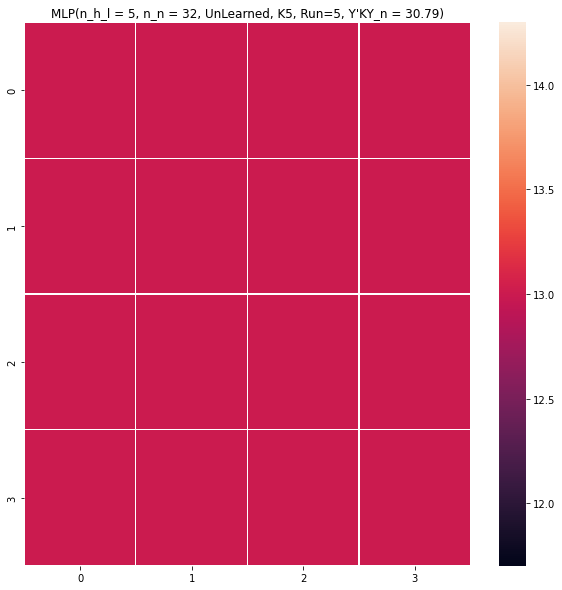

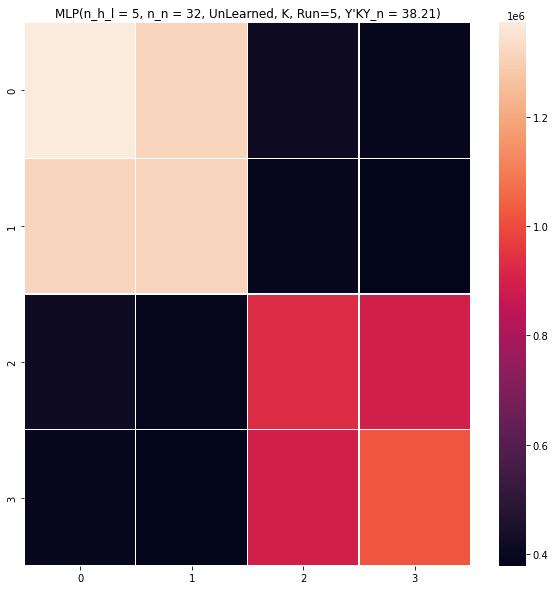

Epoch 1
-------------------------------
loss: 0.557791 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.407785 

Epoch 2
-------------------------------
loss: 0.390961 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.296091 

Epoch 3
-------------------------------
loss: 0.257894 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.266606 

Epoch 4
-------------------------------
loss: 0.266684 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.260516 

Epoch 5
-------------------------------
loss: 0.242383 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.258122 

Epoch 6
-------------------------------
loss: 0.241337 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.258458 

Epoch 7
-------------------------------
loss: 0.204361 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.257484 

Epoch 8
-------------------------------
loss: 0.153383 Batch:0 [    0/  450]
Test Error: 
 Accuracy: 0.0

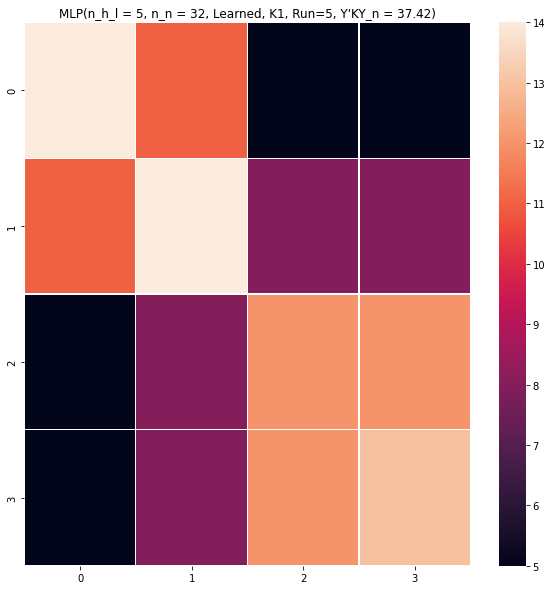

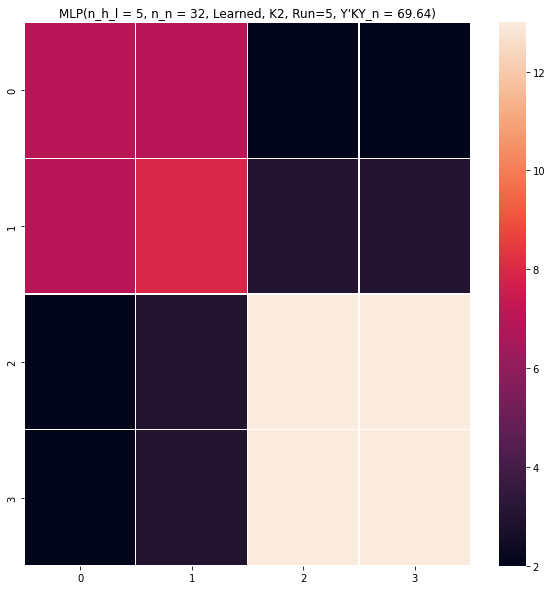

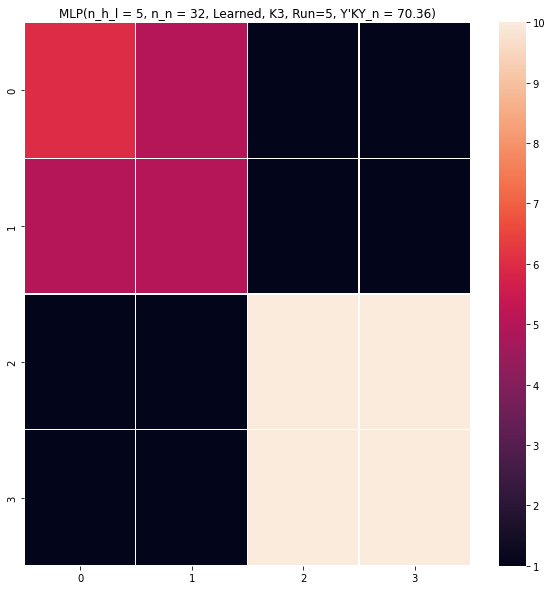

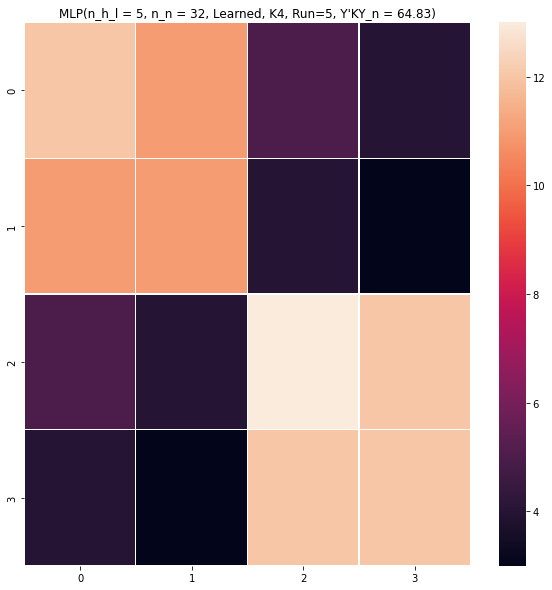

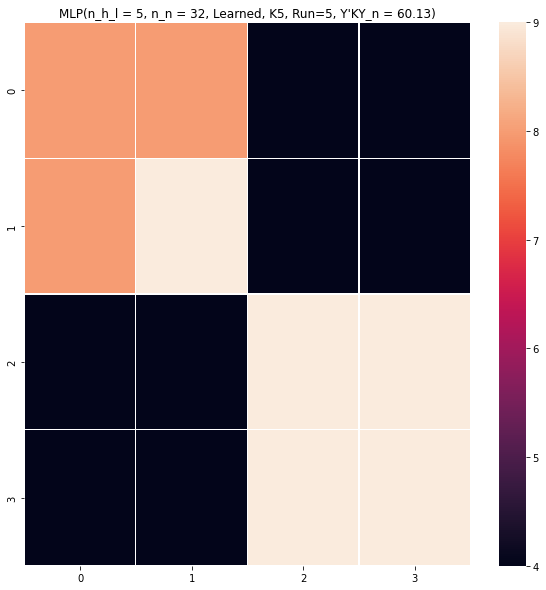

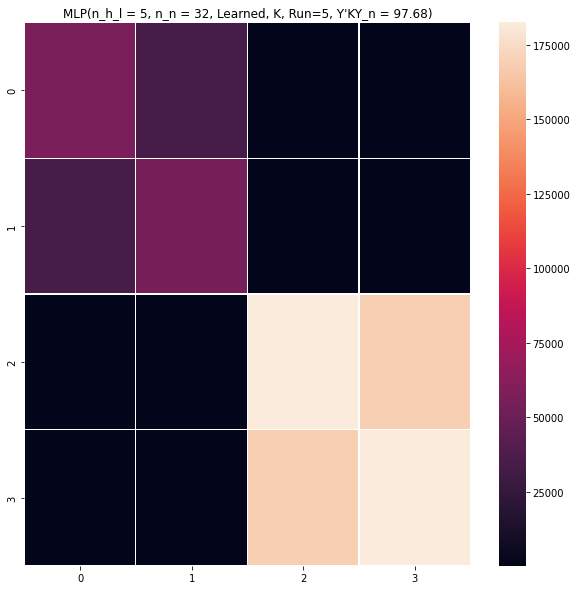

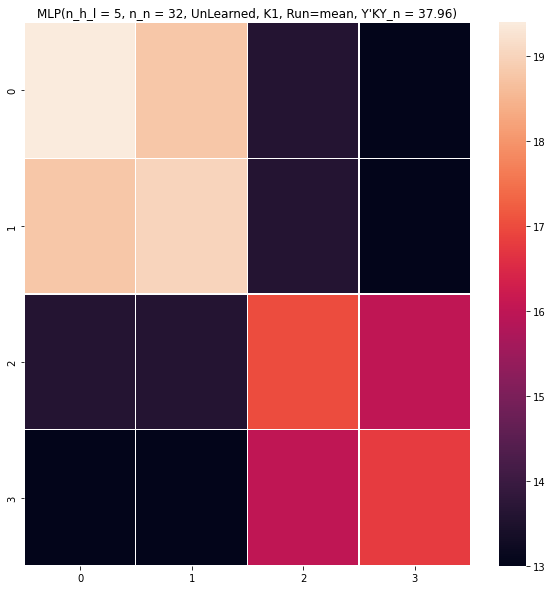

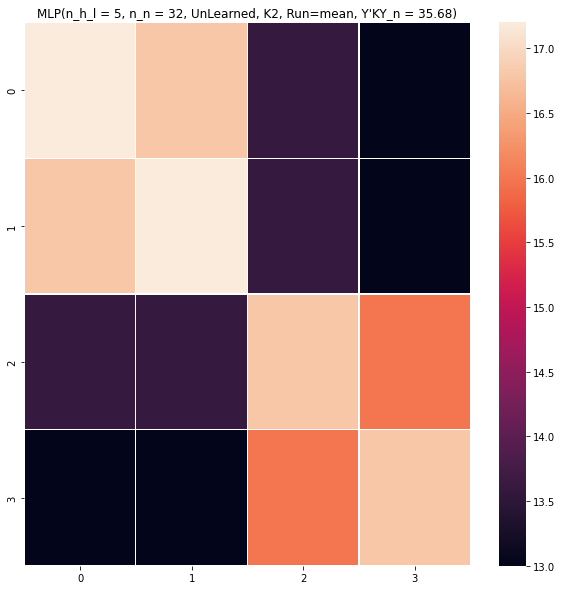

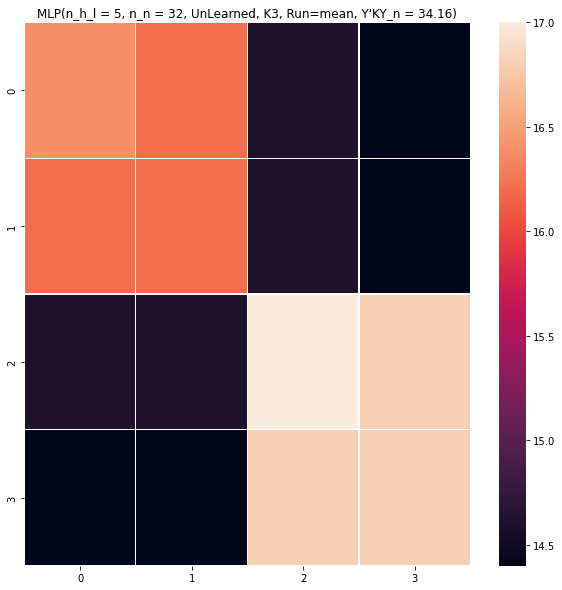

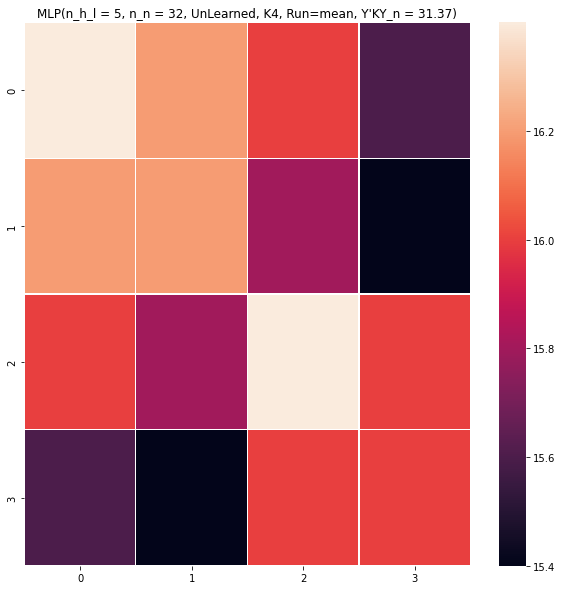

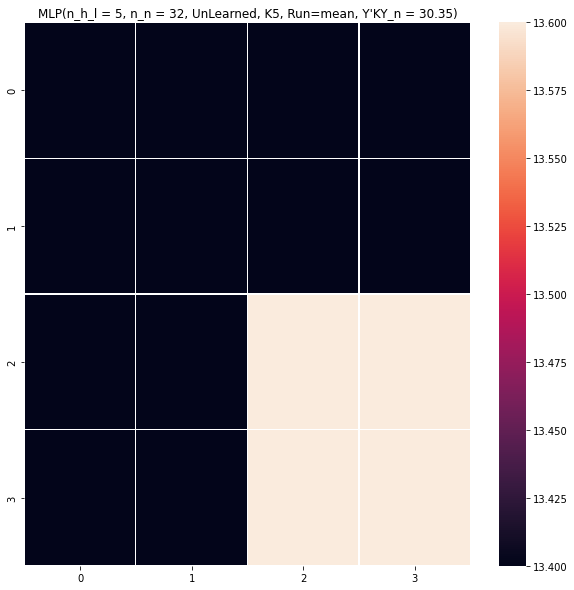

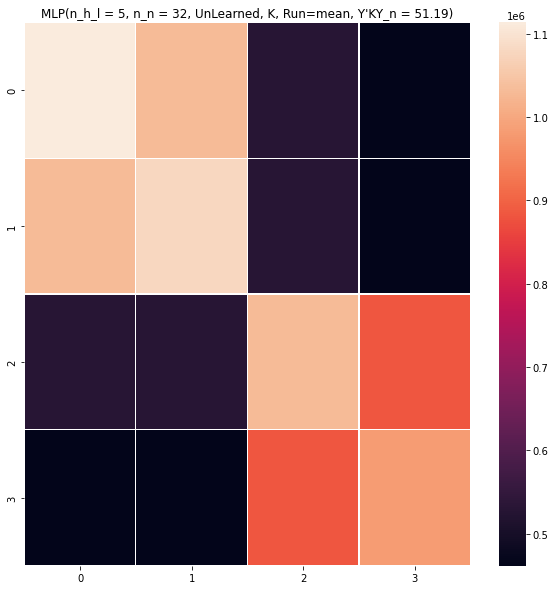

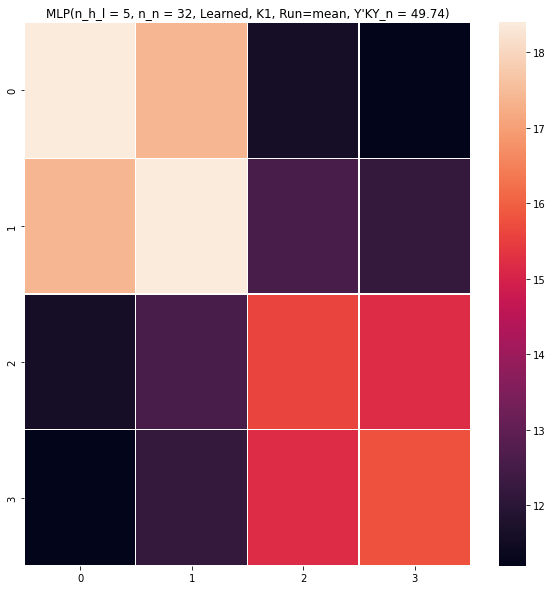

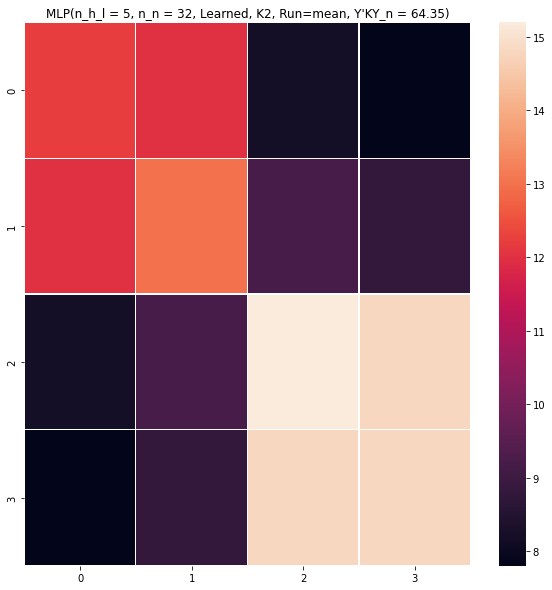

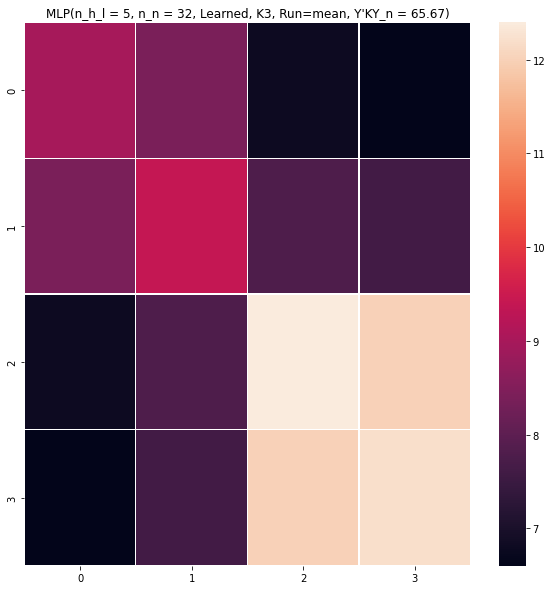

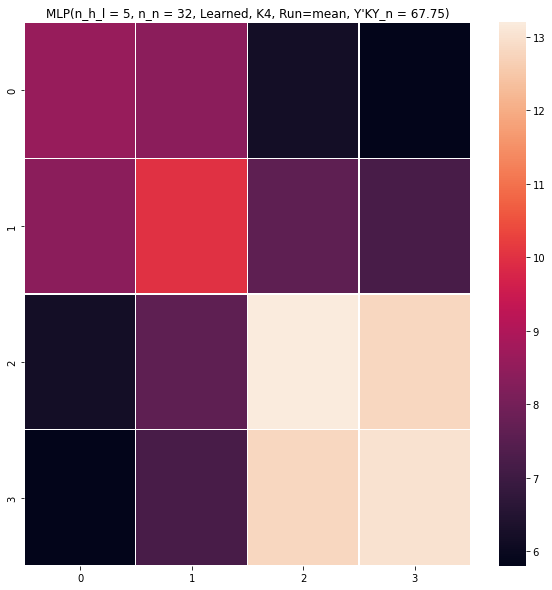

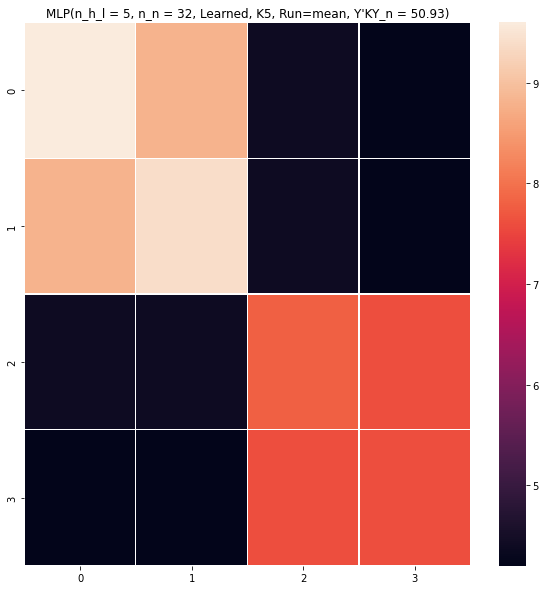

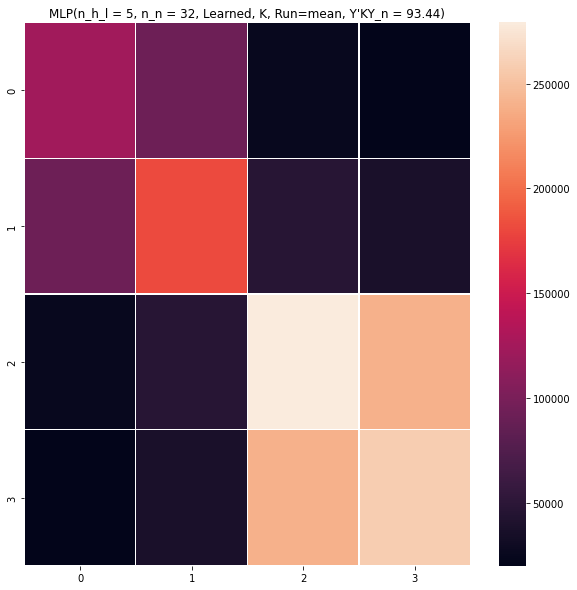

In [ ]:
# for n_h_l in [3]:
#   n_hidden_layers = n_h_l
#   for n_n in [512]:
#     n_neurons = n_n

#     model_info = {"model_architecture_type" : model_architecture_type,"n_hidden_layers":n_hidden_layers, "n_neurons" : n_neurons}
#     kernels_over_5 = []
#     for i in range(5):
#       model_info["Run"] = str(i+1)
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


all_intermediate_outs = []

info_list = []
model_architecture_type = "MLP"

for n_h_l in [5]:
  n_hidden_layers = n_h_l
  for n_n in [32]:
    n_neurons = n_n

    model_info = {"model_architecture_type" : model_architecture_type,"n_hidden_layers":n_hidden_layers, "n_neurons" : n_neurons}
    kernels_over_5 = []
    rand_kernels_over_5 = []
    for i in range(5):
      intermediate_outs = []
      model_info["Run"] = str(i+1)
      n_data_points = 500
      x1 = np.random.uniform(low = -1, high = 1, size = (n_data_points,1))
      x2 = np.random.uniform(low = -1, high = 1, size = (n_data_points,1))

      X = np.concatenate((x1, x2), axis = 1)
      X = X/np.sqrt(x1**2 + x2**2)

      Y = [ [np.sin(np.arcsin(i))] if i > 0 else [np.sin(10*np.arcsin(i))]  for i in X[:,1] ]
      Y = np.array(Y)

      n_data = len(Y)

      #plt.figure(figsize=(10,10))
      #plt.scatter(X[:,0], X[:,1], c = Y)
      #plt.savefig("Input Data")



      #sorted_arg = np.argsort(X[:, 0])
      sorted_arg = np.argsort(np.arctan2(X[:,1],X[:,0])*180/np.pi)
      X_sorted = X[sorted_arg]
      Y_sorted = Y[sorted_arg]

      batch_size = len(Y)
      dataloader = DataLoader(CustomDataset(X_sorted, Y_sorted), batch_size = batch_size, shuffle = False)
      
      batch_size = 32
      X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, shuffle = True)

      train_dataloader = DataLoader(CustomDataset(X_train, y_train), batch_size = batch_size, shuffle = True)
      test_dataloader = DataLoader(CustomDataset(X_test, y_test), batch_size = batch_size, shuffle = True)

      
#----------------get index for 4 points out of which both the pairs are separated by 10 deg
      temp = np.array(np.sort(np.arctan2(X[:,1],X[:,0])*180/np.pi), dtype = int)
      value1 = -30
      x1_idx = find_nearest(temp, value1)
      x2_idx = find_nearest(temp, value1+10)

      value2 = 40
      x3_idx = find_nearest(temp, value2)
      x4_idx = find_nearest(temp, value2+10)
#--------------

      mlp_model = NeuralNet( n_hidden_layers, n_neurons, model_architecture_type).to(device)
      loss_fn = nn.MSELoss()
      optimizer = torch.optim.Adam(mlp_model.parameters(),lr = 3e-3)  

      #weights_all_epochs = []
      #losses = []
      model_learning_status = "UnLearned"
      
      prediction, hidden_layer_outputs, _ = test(dataloader,mlp_model, loss_fn)
      #----
      intermediate_outs.append(np.array((hidden_layer_outputs[1][[x1_idx, x2_idx, x3_idx, x4_idx]]).detach().to('cpu')))
      #----
      kernels = get_kernels(hidden_layer_outputs)
      rand_kernels_over_5.append(kernels)
      YKYs = []
      for i in range(len(kernels)):
        YKY = np.matmul(np.matmul(Y_sorted.T, kernels[i]), Y_sorted)
        eigen_vals = eigh(kernels[i], eigvals_only = True)
        YKYs.append(str(round(YKY[0][0]/eigen_vals[-1], 2)))
        

      model_info["Y'KY"] = YKYs
      plot_heatmap(kernels, model_info)


      epochs = 100
      for t in range(epochs):
          print(f"Epoch {t+1}\n-------------------------------")
          #get_layer_weights()

          pred = train(train_dataloader,mlp_model, loss_fn, optimizer)
          # _,_, loss = test(test_dataloader,mlp_model, loss_fn)

          #----
          prediction, hidden_layer_outputs, _ = test(dataloader,mlp_model, loss_fn)
          intermediate_outs.append(np.array((hidden_layer_outputs[1][[x1_idx, x2_idx, x3_idx, x4_idx]]).detach().to('cpu')))
          #----
          #losses.append(loss)
      print("Done!")
      all_intermediate_outs.append(intermediate_outs)
      model_learning_status = "Learned"

      prediction, hidden_layer_outputs,_ = test(dataloader,mlp_model, loss_fn)

      kernels = get_kernels(hidden_layer_outputs)
      kernels_over_5.append(kernels)
      YKYs = []
      for i in range(len(kernels)):
        YKY = np.matmul(np.matmul(Y_sorted.T, kernels[i]), Y_sorted)
        eigen_vals = eigh(kernels[i], eigvals_only = True)
        YKYs.append(str(round(YKY[0][0]/eigen_vals[-1], 2)))
      
      model_info["Y'KY"] = YKYs
      plot_heatmap(kernels, model_info)


    

    kernels_mean = np.mean(np.array(rand_kernels_over_5), axis = 0)
    YKYs = []
    for i in range(len(kernels_mean)):
      YKY = np.matmul(np.matmul(Y_sorted.T, kernels_mean[i]), Y_sorted)
      eigen_vals = eigh(kernels_mean[i], eigvals_only = True)
      YKYs.append(str(round(YKY[0][0]/eigen_vals[-1], 2)))
    
    model_learning_status = "UnLearned"
    model_info["Y'KY"] = YKYs
    model_info["Run"] = "mean"
    model_info["model_learning_status"] = "UnLearned"
    info_list.append(list(model_info.values()).copy())
    plot_heatmap(kernels_mean, model_info)
    
    



    kernels_mean = np.mean(np.array(kernels_over_5), axis = 0)
    YKYs = []
    for i in range(len(kernels_mean)):
      YKY = np.matmul(np.matmul(Y_sorted.T, kernels_mean[i]), Y_sorted)
      eigen_vals = eigh(kernels_mean[i], eigvals_only = True)
      YKYs.append(str(round(YKY[0][0]/eigen_vals[-1], 2)))
    model_learning_status = "Learned"
    model_info["Y'KY"] = YKYs
    model_info["Run"] = "mean"
    model_info["model_learning_status"] = "Learned"
    info_list.append(list(model_info.values()).copy())
    plot_heatmap(kernels_mean, model_info)

In [ ]:
# !rm -r /content/*

In [ ]:
!zip -r 4_input_kernels_DGN.zip /content

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 24%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2022.01.07/ (stored 0%)
  adding: content/.config/logs/2022.01.07/14.32.37.114755.log (deflated 91%)
  adding: content/.config/logs/2022.01.07/14.33.41.864886.log (deflated 54%)
  adding: content/.config/logs/2022.01.07/14.33.42.565580.log (deflated 53%)
  adding: content/.config/logs/2022.01.07/14.33.15.504888.log (deflated 86%)
  adding: content/.config/logs/2022.01.07/14.33.22.232212.log (deflated 54%)
  adding: content/.config/logs/2022.01.07/14.32.57.118850.log (deflated 53%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.con

In [ ]:
temp = []
for i in range(5):
  if i ==0:
    temp = np.concatenate(all_intermediate_outs[i], axis = 0)
  else:
    temp += np.concatenate(all_intermediate_outs[i], axis = 0)
temp /= 5
intermediate_outs = temp

In [ ]:
intermediate_outs.shape

(1004, 32)

In [ ]:
plotx1 = intermediate_outs[0:-1:4]
plotx2 = intermediate_outs[1:-1:4]
plotx3 = intermediate_outs[2:-1:4]
plotx4 = intermediate_outs[3:-1:4]

In [ ]:
plotx1 = np.sqrt(np.mean(np.square(plotx1), axis = 1))
plotx2 = np.sqrt(np.mean(np.square(plotx2), axis = 1))
plotx3 = np.sqrt(np.mean(np.square(plotx3), axis = 1))
plotx4 = np.sqrt(np.mean(np.square(plotx4), axis = 1))

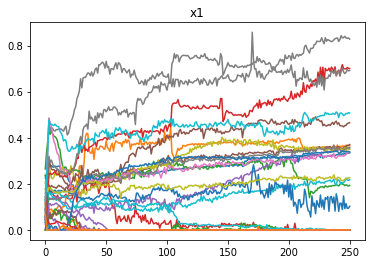

In [ ]:
plt.plot(plotx1)
plt.title('x1')
plt.savefig('x1_plot.png')

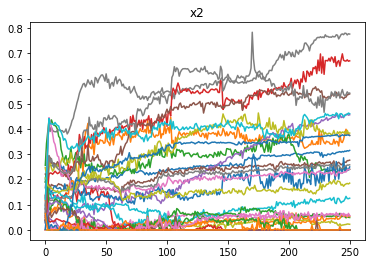

In [ ]:
plt.plot(plotx2)
plt.title('x2')
plt.savefig('x2_plot.png')

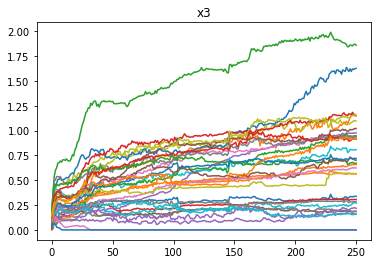

In [ ]:
plt.plot(plotx3)
plt.title('x3')
plt.savefig('x3_plot.png')

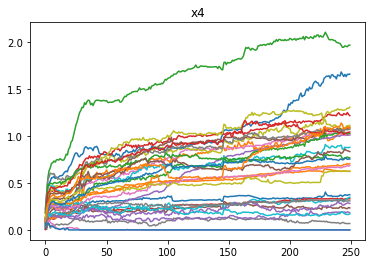

In [ ]:
plt.plot(plotx4)
plt.title('x4')
plt.savefig('x4_plot.png')

In [ ]:
hidden_layer_outputs[0].size()

torch.Size([500, 32])

In [ ]:
# plot_heatmap(kernels_mean, model_info)

**Testing Layer by Layer Hypothesis**

In [ ]:

def get_layer_weights():
  l1_weight = mlp_model.fc1.weight.detach().to("cpu").numpy()
  l2_weight = mlp_model.fc2.weight.detach().to("cpu").numpy()
  l3_weight = mlp_model.fc3.weight.detach().to("cpu").numpy()
  weights_all_epochs.append([l1_weight, l2_weight, l3_weight])



In [ ]:

change = []
for i in range(len(weights_all_epochs)):
  layer1_diff = weights_all_epochs[i][0]-weights_all_epochs[0][0]
  other_layer_diff = np.array(weights_all_epochs[i][1:])-np.array(weights_all_epochs[0][1:])
  change.append([np.mean(np.square(layer1_diff)),np.mean(np.square(other_layer_diff[0])), np.mean(np.square(other_layer_diff[1]))])

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(len(change)), np.array(change)[:,0], label = "Layer 1")
plt.plot(np.arange(len(change)), np.array(change)[:,1], label = "Layer 2")
plt.plot(np.arange(len(change)), np.array(change)[:,2], label = "Lay4er 3")
plt.plot(np.arange(len(change)),losses, label = "Test loss")

plt.legend()
plt.show()

In [ ]:
interval = 2
change = []
for i in range(5,len(weights_all_epochs)):
  layer1_diff = weights_all_epochs[i][0]-weights_all_epochs[i-interval][0]
  other_layer_diff = np.array(weights_all_epochs[i][1:])-np.array(weights_all_epochs[i-interval][1:])
  change.append([np.mean(np.square(layer1_diff)),np.mean(np.square(other_layer_diff[0])), np.mean(np.square(other_layer_diff[1]))])

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(np.arange(len(change)), np.array(change)[:,0], label = "Layer 1")
plt.plot(np.arange(len(change)), np.array(change)[:,1], label = "Layer 2")
plt.plot(np.arange(len(change)), np.array(change)[:,2], label = "Layer 3")
#plt.plot(np.arange(len(change)+1),losses, label = "Test loss")

plt.legend()
plt.show()

In [ ]:
interval = 3
change = []
layer1_diffs = []
other_layer_diffs = []
for i in range(5,len(weights_all_epochs)):
  layer1_diff = np.square(weights_all_epochs[i][0]-weights_all_epochs[i-interval][0])
  other_layer_diff =  np.square(np.array(weights_all_epochs[i][1:])-np.array(weights_all_epochs[i-interval][1:]))
  layer1_diffs.append(layer1_diff.flatten())
  other_layer_diffs.append([other_layer_diff[0].flatten(), other_layer_diff[1].flatten()])

In [ ]:
plt.figure(figsize=(20,20))
#plt.plot(np.arange(len(layer1_diffs)), layer1_diffs, label = "Layer 1", color = "blue")
plt.plot(np.arange(len(layer1_diffs)), np.array(other_layer_diffs)[:,0], label = "Layer 2", color = "orange")
plt.plot(np.arange(len(layer1_diffs)), np.array(other_layer_diffs)[:,1], label = "Layer 3", color = "green")
plt.plot(np.arange(len(layer1_diffs)), layer1_diffs, label = "Layer 1", color = "blue")
#plt.plot(np.arange(len(change)+1),losses, label = "Test loss")

plt.legend()
plt.show()

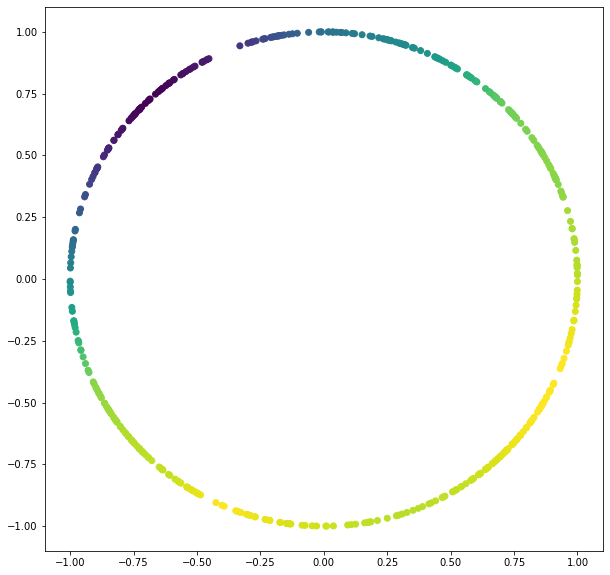

In [ ]:
# plt.figure(figsize=(10,10))
# plt.scatter(X_sorted[:,0], X_sorted[:,1], c = prediction.to("cpu"))
# plt.savefig("Regenerated ("+model_learning_status+')')

In [ ]:
#np.matmul(np.matmul(Y_sorted.T, np.linalg.pinv(kernels[-1])), Y_sorted)

array([[0.06021548]])

**NPF-NPV Framework**

In [ ]:
x1 = np.random.uniform(low = -1, high = 1, size = (500,1))
x2 = np.random.uniform(low = -1, high = 1, size = (500,1))

X = np.concatenate((x1, x2), axis = 1)
X = X/np.sqrt(x1**2 + x2**2)

Y = [ [np.sin(np.arcsin(i))] if i > 0 else [np.sin(10*np.arcsin(i))]  for i in X[:,1] ]
Y = np.array(Y)

n_data = len(Y)

#plt.figure(figsize=(10,10))
#plt.scatter(X[:,0], X[:,1], c = Y)
#plt.savefig("Input Data")

class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.size = len(Y)
        self.x = torch.tensor(X)
        self.y = torch.tensor(Y)

    def __len__(self):
        return (self.size)

    def __getitem__(self, idx):
        #print(self.x[idx].shape,self.y[idx].shape )
        return self.x[idx].float(), self.y[idx].float()


#sorted_arg = np.argsort(X[:, 0])
sorted_arg = np.argsort(np.arctan2(X[:,1],X[:,0])*180/np.pi)
X_sorted = X[sorted_arg]
Y_sorted = Y[sorted_arg]

batch_size = len(Y)
dataloader = DataLoader(CustomDataset(X_sorted, Y_sorted), batch_size = batch_size, shuffle = False)


batch_size = 32
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, shuffle = True)

train_dataloader = DataLoader(CustomDataset(X_train, y_train), batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(CustomDataset(X_test, y_test), batch_size = batch_size, shuffle = True)











class NPFNeuralNetwork(nn.Module):
    def __init__(self, n_hidden_layers, n_neurons, architecture_type):
        super(NPFNeuralNetwork, self).__init__()
        self.architecture_type = architecture_type
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons

        
        self.layers = nn.ModuleList([nn.Linear(2,  self.n_neurons, bias = True).to(device)])
        #self.dlgn_Sf_layers = nn.ModuleList([nn.Linear(2,  self.n_neurons).to(device)])
        
        if self.architecture_type == "DLGN-SF":
          for i in range(self.n_hidden_layers-1):
            self.layers.append(nn.Linear( 2,  self.n_neurons, bias = True).to(device))
        
        else:
          for i in range(self.n_hidden_layers-1):
            self.layers.append(nn.Linear( self.n_neurons,  self.n_neurons).to(device))
        
        
        
        self.layers.append(nn.Linear( self.n_neurons, 1, bias = True).to(device))
  
        
    def forward(self, x):
        hidden_layer_outputs = []
      
        if self.architecture_type == "DGN":
          for i in range(len(self.layers)-1):
            x = self.layers[i](x)
            out = torch.relu(x)
            hidden_layer_outputs.append(out)
            x = out
          #x = self.layers[len(layers)-1](x)

        elif  self.architecture_type == "DLGN":
          for i in range(len(self.layers)-1):
            x = self.layers[i](x)
            out = x
            hidden_layer_outputs.append(out)
            x = out
          #x = self.layers[len(layers)-1](x)

        elif  self.architecture_type == "DLGN-SF":
          for i in range(len(self.layers)-1):
            out = self.layers[i](x)
            hidden_layer_outputs.append(out)
            
        

        return hidden_layer_outputs



class NPVNeuralNetwork(nn.Module):
    def __init__(self, n_hidden_layers, n_neurons):
        super(NPVNeuralNetwork, self).__init__()
  
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons

        self.layers = nn.ModuleList([nn.Linear(2,  self.n_neurons).to(device)])
      
        for i in range(self.n_hidden_layers-1):
          self.layers.append(nn.Linear( self.n_neurons,  self.n_neurons).to(device))
          
        self.layers.append(nn.Linear( self.n_neurons, 1).to(device))

        self.gate = Gate()
      
    def forward(self, x, gating_mask):

        hidden_layer_outputs = []
      
        for i in range(len(self.layers)-1):
          x = self.layers[i](x)
          
          out = self.gate(x, i, gating_mask)
          hidden_layer_outputs.append(out)
          x = out
        x = self.layers[len(self.layers)-1](x)
        #print("debug 2", x.shape, x)
        return x,  hidden_layer_outputs


def apply_gate(beta, idx, gating_mask):
  out = beta*(gating_mask[idx])
  return out
  
class Gate(nn.Module):
    def __init__(self, beta = 4):
        super(Gate,self).__init__()
        self.beta = beta

    def forward(self, x, idx, gating_mask):
      #Soft Relu
      return torch.mul(x,torch.sigmoid(apply_gate(self.beta, idx,gating_mask)))

      #Hard Relu
      #return torch.mul(x,torch.sign(gating_mask[idx]))



def train_decoupled(X1_dataloader,X2_dataloader, npf_model, npv_model, loss_fn, optimizer):
    size = len(X1_dataloader.dataset)
    correct = 0
    for batch, ((X1, y1), (X2,y2)) in enumerate(zip(X1_dataloader, X2_dataloader)):
        X1, y1 = X1.to(device), y1.to(device)
        X2, y2 = X2.to(device), y2.to(device)
        
        npf_model_hidden_layer_outs = npf_model(X1)
        pred, npv_model_hidden_layer_outs = npv_model(X2, npf_model_hidden_layer_outs)
        #print("Debug1 ", pred.shape)
        loss = loss_fn(pred, y1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch%10 == 0:
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            loss, current = loss.item(), batch * len(X1)
            print(f"loss: {loss:>7f} Batch:{batch} [{current:>5d}/{size:>5d}]")
    return pred # pred for only batch is returned

def test_decoupled(dataloader, npf_model, npv_model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    npf_model.eval()
    npv_model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            npf_model_hidden_layer_outs = npf_model(X)
            pred, npv_model_hidden_layer_outs = npv_model(X, npf_model_hidden_layer_outs)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return pred, npf_model_hidden_layer_outs



'''
n_hidden_layers = 3
n_neurons = 32
model_architecture_type = "DLGN-SF"
model_info = {"model_architecture_type" : model_architecture_type,"n_hidden_layers":n_hidden_layers, "n_neurons" : n_neurons}

npf_model = NPFNeuralNetwork(n_hidden_layers, n_neurons, model_architecture_type).to(device)
npv_model = NPVNeuralNetwork(n_hidden_layers, n_neurons).to(device)
model_learning_status = "UnLearned"


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam([
                {'params': npf_model.parameters()},
                {'params': npv_model.parameters()}],
                lr = 3e-3) 


epochs = 300

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_decoupled(train_dataloader,train_dataloader,npf_model, npv_model, loss_fn, optimizer)
    test_decoupled(test_dataloader,npf_model, npv_model, loss_fn)
    
print("Done!")
model_learning_status = "Learned"


prediction, hidden_layer_outputs = test_decoupled(dataloader,npf_model, npv_model, loss_fn)
kernels = get_kernels(hidden_layer_outputs)
kernels_over_5.append(kernels)
#plot_heatmap(kernels,model_info)
'''

'\nn_hidden_layers = 3\nn_neurons = 32\nmodel_architecture_type = "DLGN-SF"\nmodel_info = {"model_architecture_type" : model_architecture_type,"n_hidden_layers":n_hidden_layers, "n_neurons" : n_neurons}\n\nnpf_model = NPFNeuralNetwork(n_hidden_layers, n_neurons, model_architecture_type).to(device)\nnpv_model = NPVNeuralNetwork(n_hidden_layers, n_neurons).to(device)\nmodel_learning_status = "UnLearned"\n\n\nloss_fn = nn.MSELoss()\noptimizer = torch.optim.Adam([\n                {\'params\': npf_model.parameters()},\n                {\'params\': npv_model.parameters()}],\n                lr = 3e-3) \n\n\nepochs = 300\n\nfor t in range(epochs):\n    print(f"Epoch {t+1}\n-------------------------------")\n    train_decoupled(train_dataloader,train_dataloader,npf_model, npv_model, loss_fn, optimizer)\n    test_decoupled(test_dataloader,npf_model, npv_model, loss_fn)\n    \nprint("Done!")\nmodel_learning_status = "Learned"\n\n\nprediction, hidden_layer_outputs = test_decoupled(dataloader,npf

In [ ]:
# kernels_over_5 = []

In [ ]:
def some_routine(kernels_5):
  prediction, hidden_layer_outputs = test_decoupled(dataloader,npf_model, npv_model, loss_fn)
  kernels = get_kernels(hidden_layer_outputs)
  kernels_5.append(kernels)
  YKY = np.matmul(np.matmul(Y_sorted.T, kernels[-1]), Y_sorted)
  eigen_vals = eigh(kernels[-1], eigvals_only = True)
  model_info["Y'KY"] = str(round(YKY[0][0]/eigen_vals[-1], 2))
  plot_heatmap(kernels, model_info)

Test Error: 
 Avg loss: 0.471054 



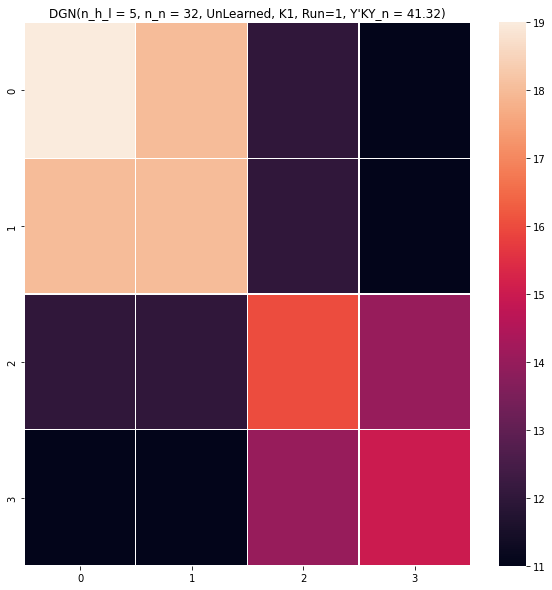

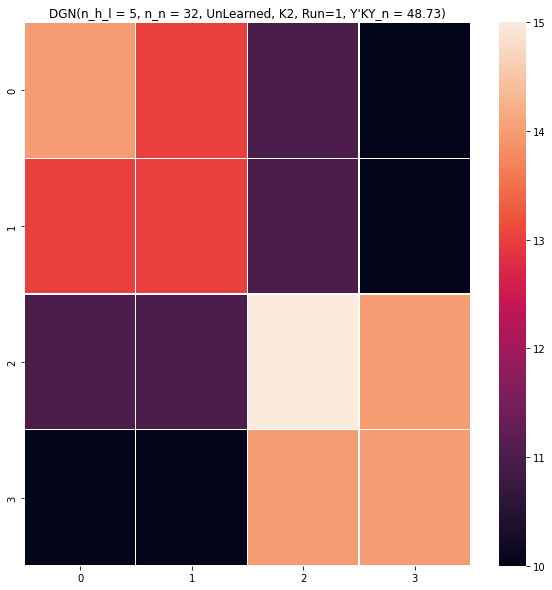

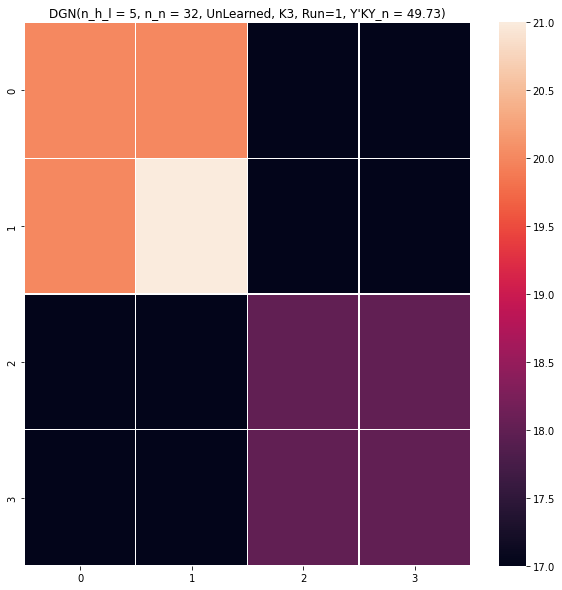

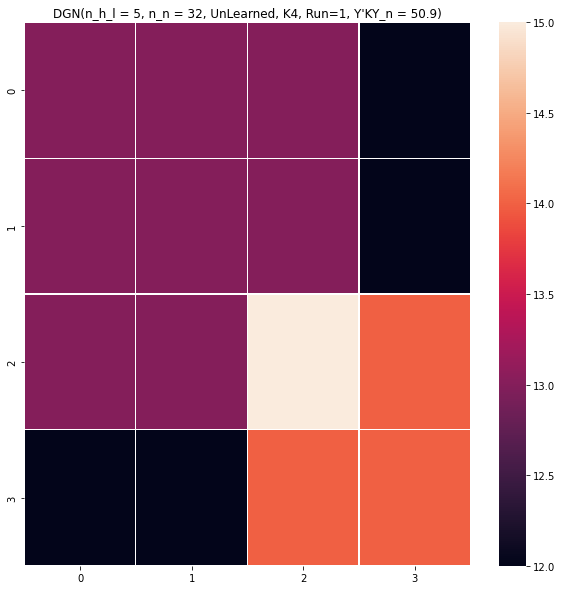

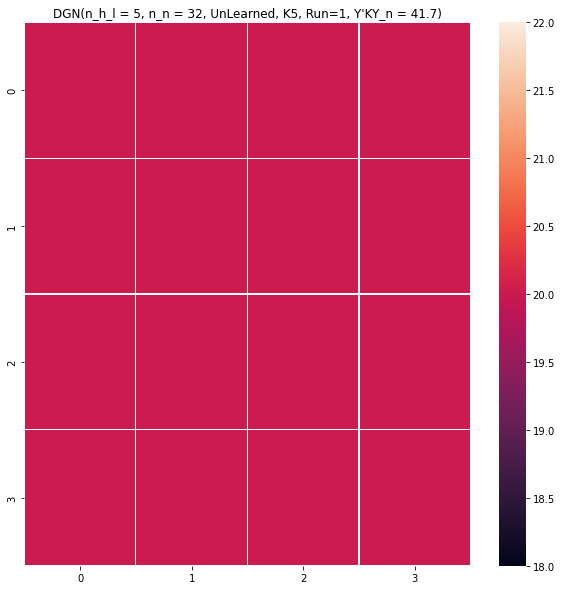

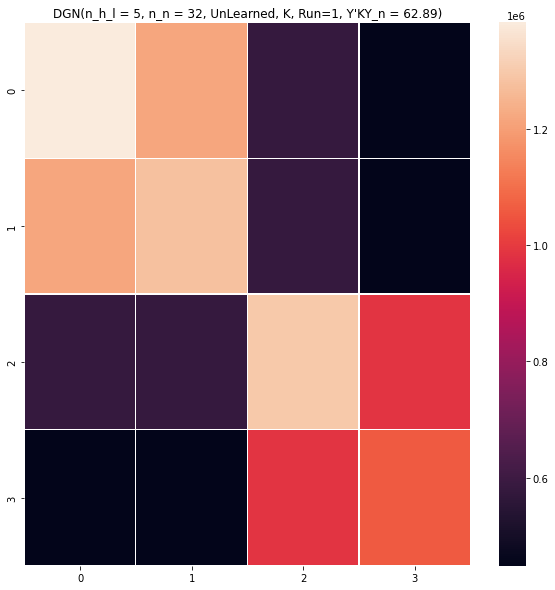

Epoch 1
-------------------------------
loss: 0.492924 Batch:0 [    0/  450]
loss: 0.401209 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.450645 

Test Error: 
 Avg loss: 0.374600 

Epoch 2
-------------------------------
loss: 0.479966 Batch:0 [    0/  450]
loss: 0.362022 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.314261 

Test Error: 
 Avg loss: 0.269501 

Epoch 3
-------------------------------
loss: 0.306579 Batch:0 [    0/  450]
loss: 0.375984 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.266503 

Test Error: 
 Avg loss: 0.261849 

Epoch 4
-------------------------------
loss: 0.225311 Batch:0 [    0/  450]
loss: 0.231846 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.283275 

Test Error: 
 Avg loss: 0.239604 

Epoch 5
-------------------------------
loss: 0.209211 Batch:0 [    0/  450]
loss: 0.246412 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.262672 

Test Error: 
 Avg loss: 0.241694 

Epoch 6
-------------------------------
loss: 0.272991 Batch:0 [    0/  450

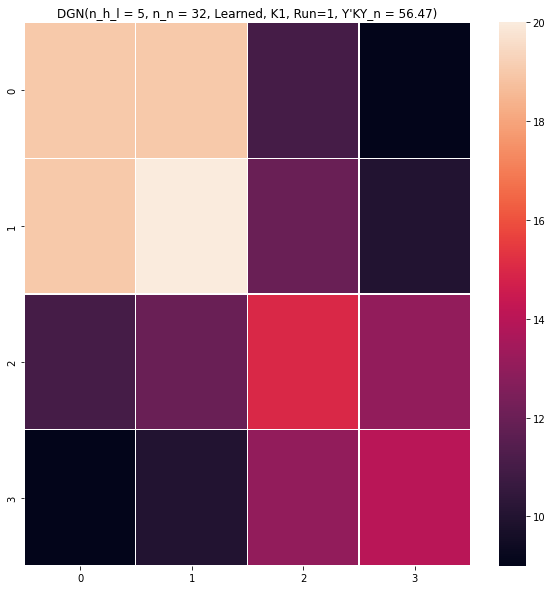

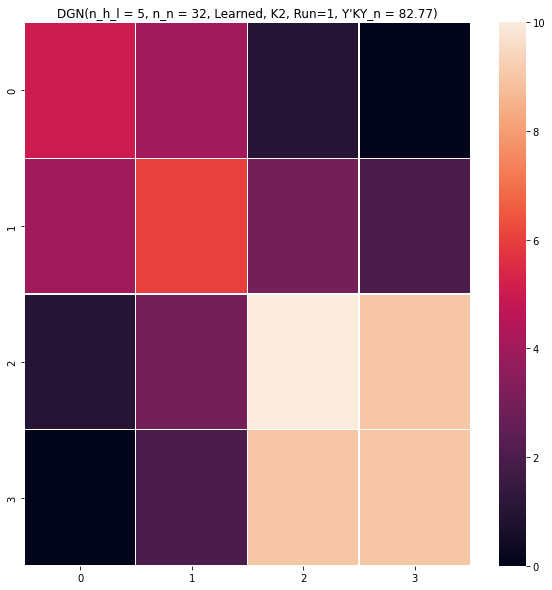

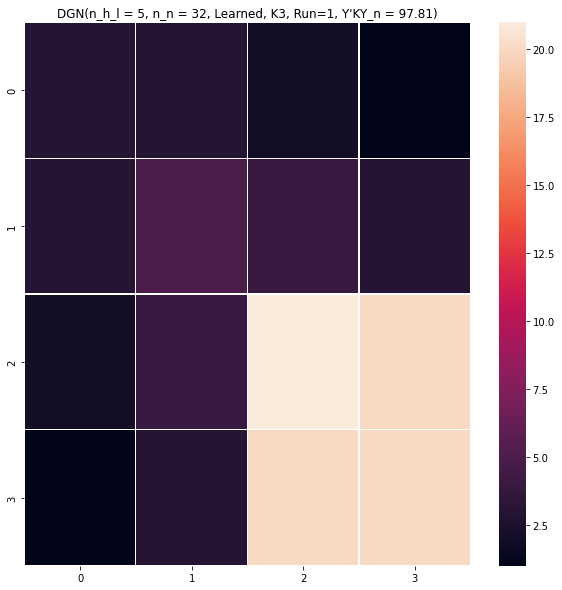

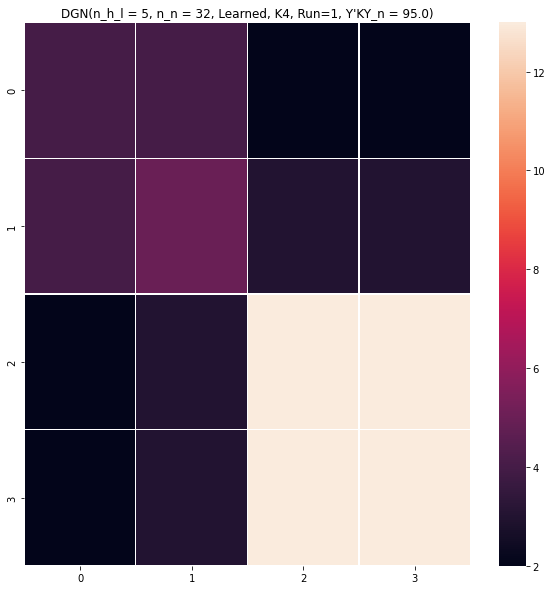

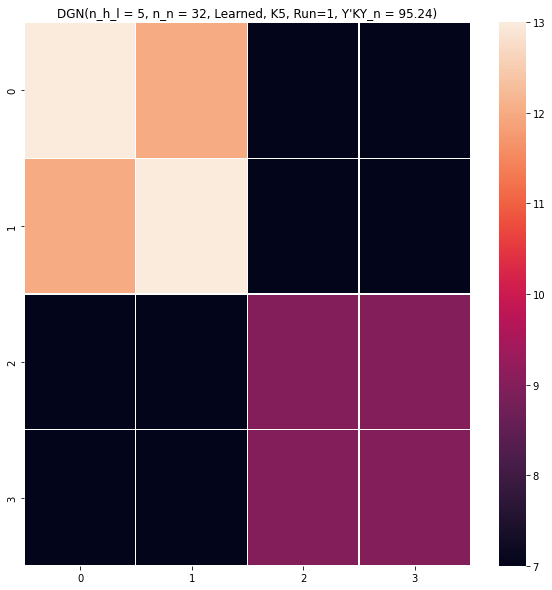

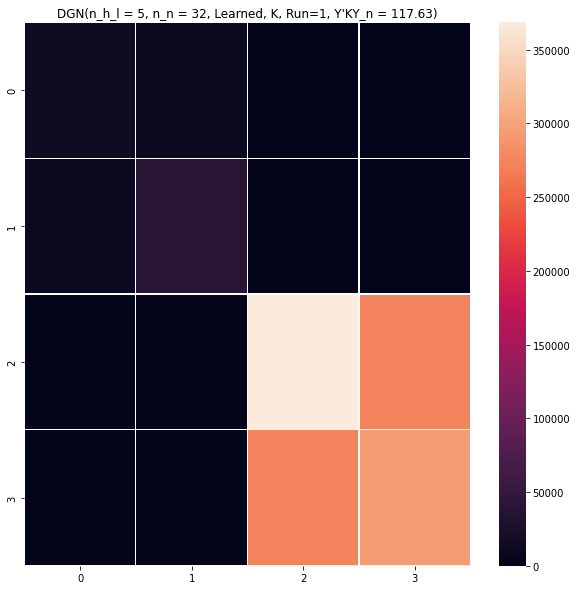

Test Error: 
 Avg loss: 0.462142 



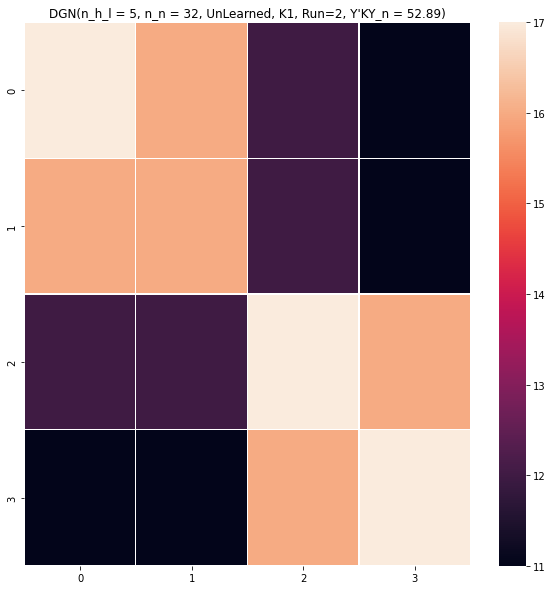

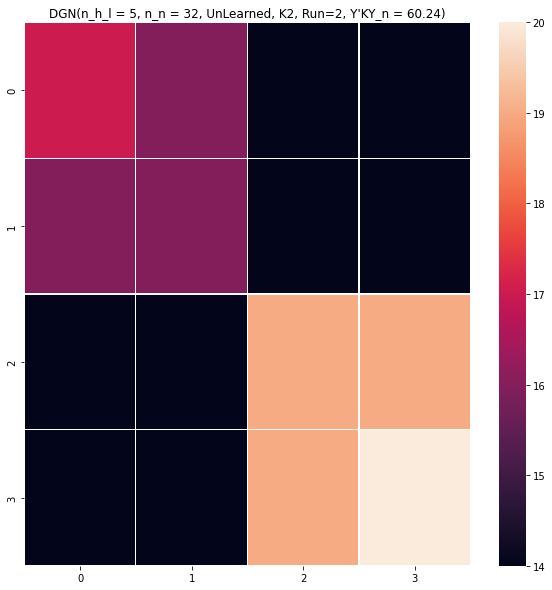

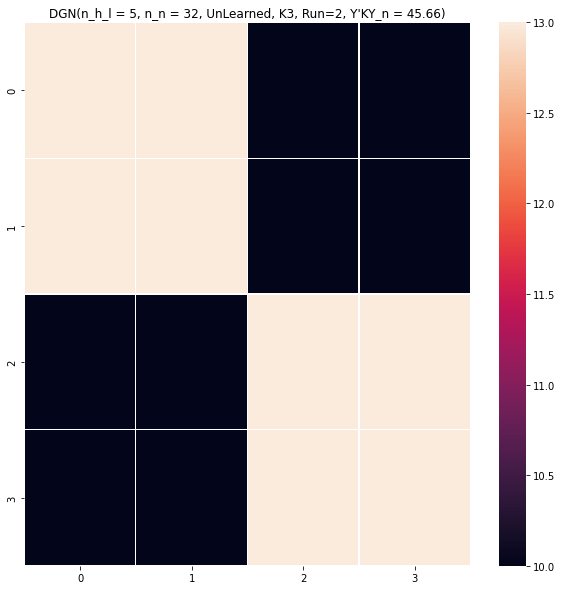

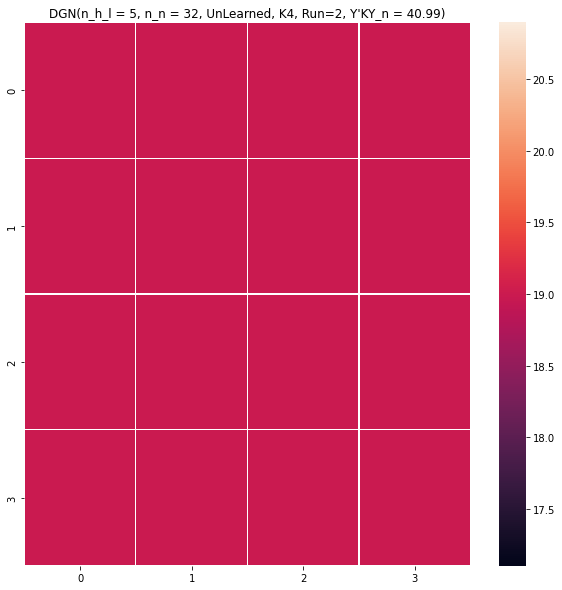

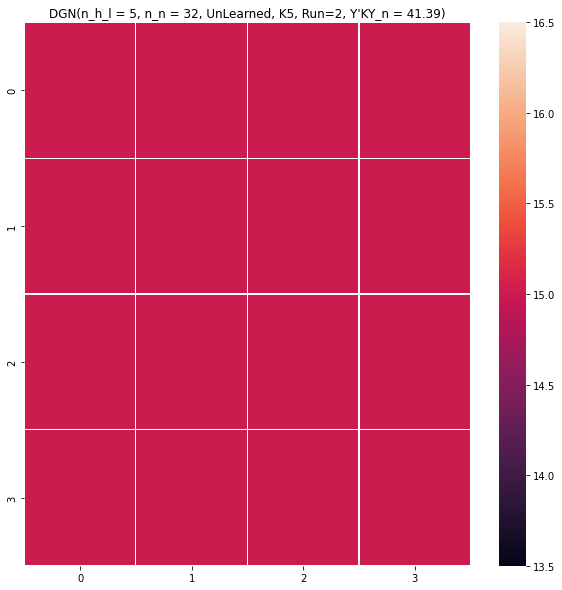

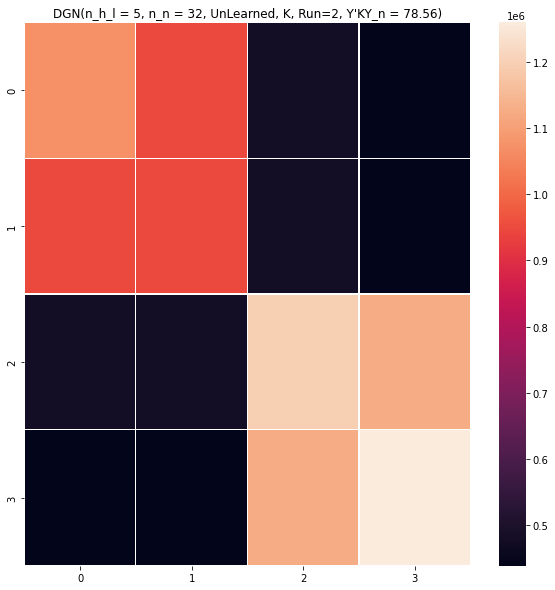

Epoch 1
-------------------------------
loss: 0.457650 Batch:0 [    0/  450]
loss: 0.566199 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.374908 

Test Error: 
 Avg loss: 0.388949 

Epoch 2
-------------------------------
loss: 0.374341 Batch:0 [    0/  450]
loss: 0.378962 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.305863 

Test Error: 
 Avg loss: 0.302646 

Epoch 3
-------------------------------
loss: 0.334652 Batch:0 [    0/  450]
loss: 0.252064 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.240734 

Test Error: 
 Avg loss: 0.244311 

Epoch 4
-------------------------------
loss: 0.337136 Batch:0 [    0/  450]
loss: 0.170770 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.310008 

Test Error: 
 Avg loss: 0.255879 

Epoch 5
-------------------------------
loss: 0.349966 Batch:0 [    0/  450]
loss: 0.282226 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.260308 

Test Error: 
 Avg loss: 0.234145 

Epoch 6
-------------------------------
loss: 0.183025 Batch:0 [    0/  450

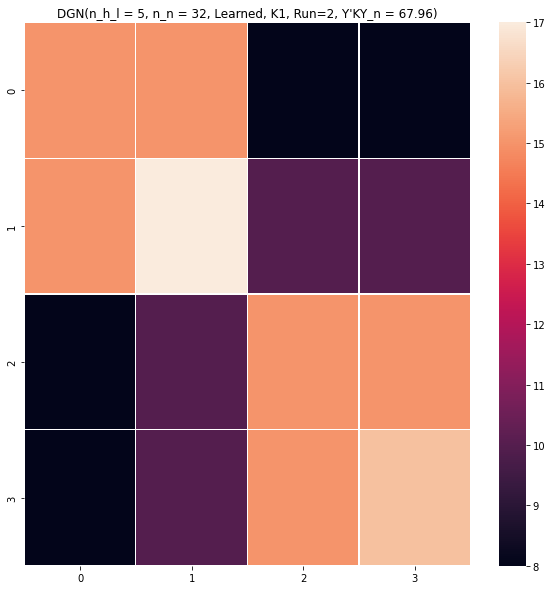

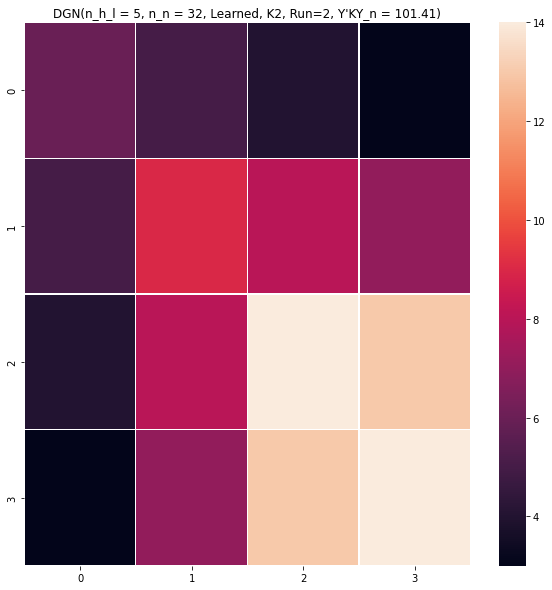

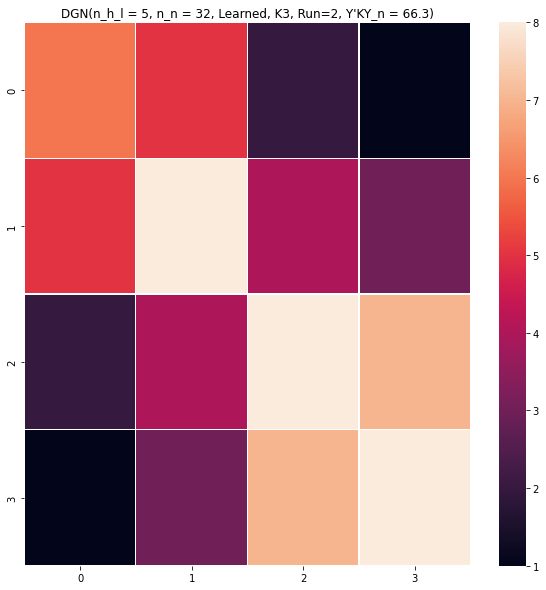

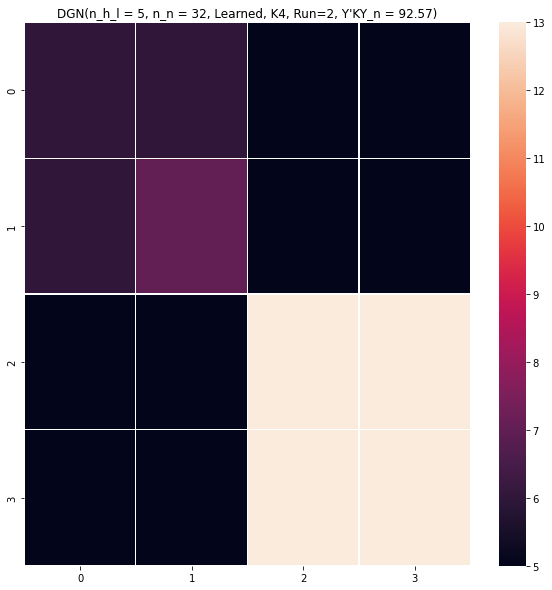

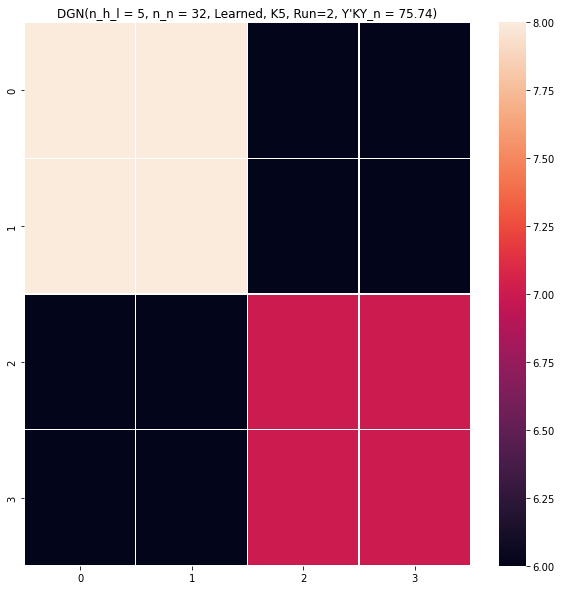

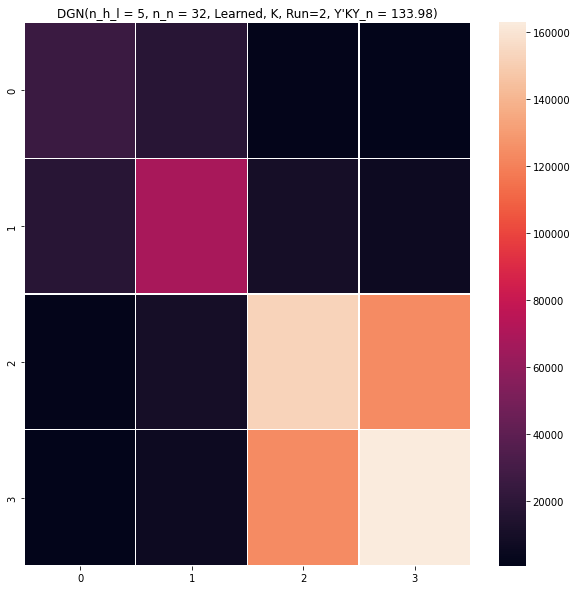

Test Error: 
 Avg loss: 0.544586 



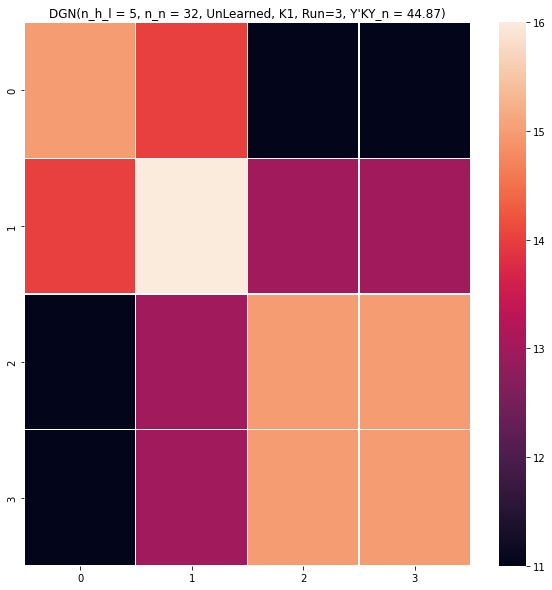

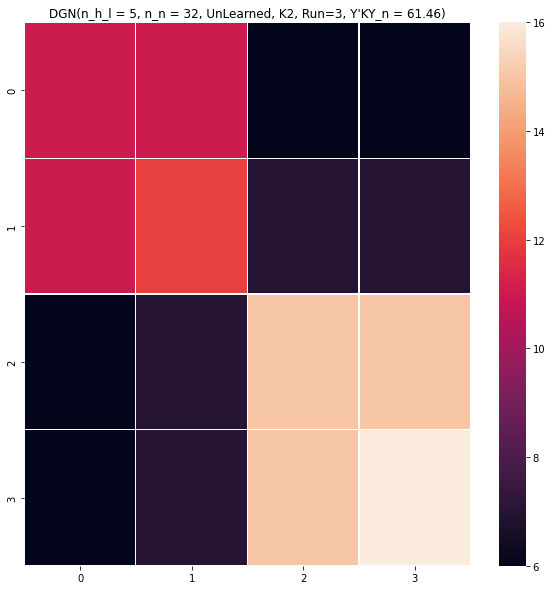

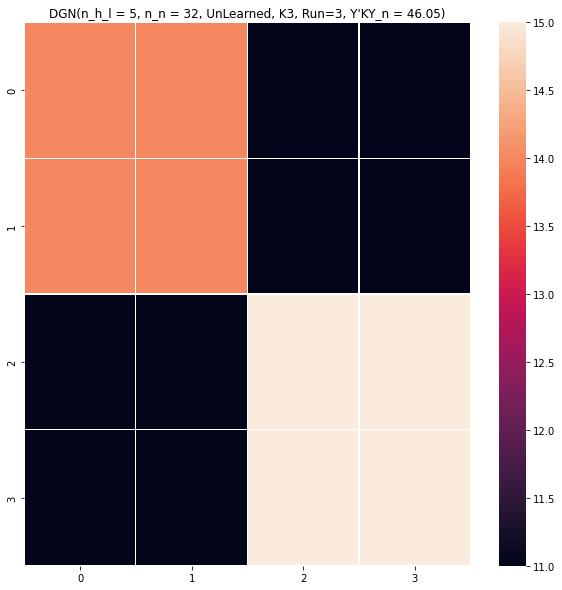

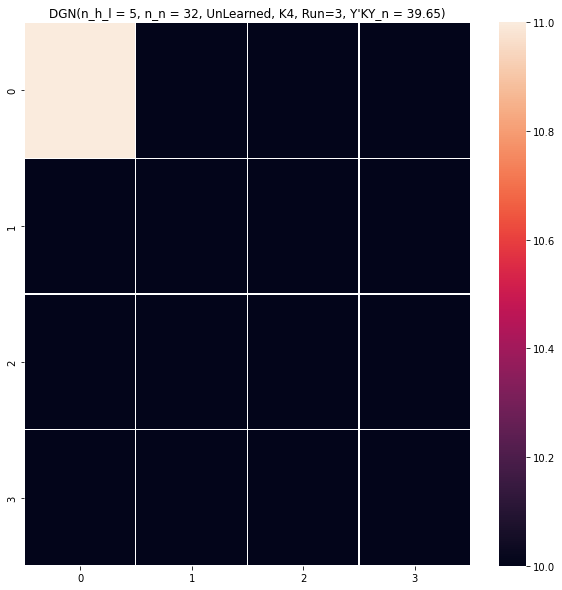

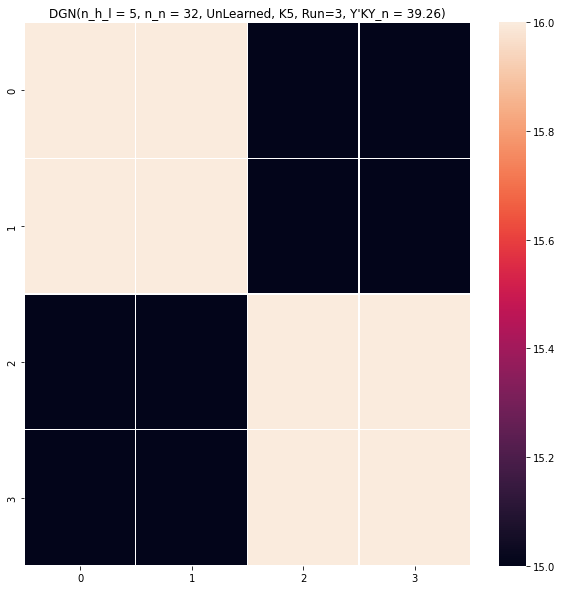

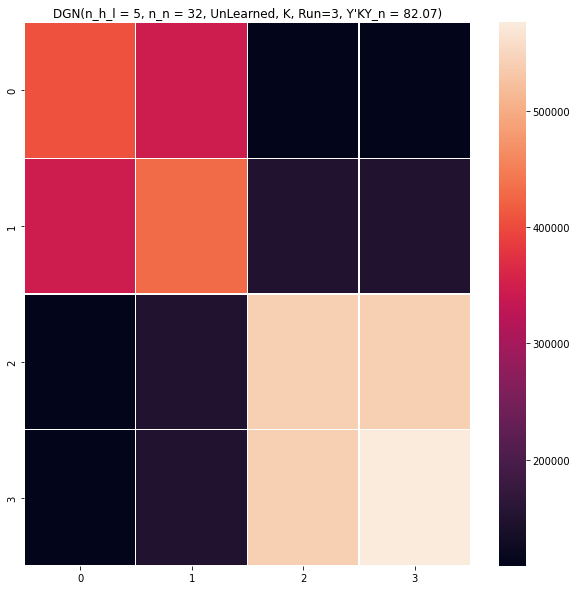

Epoch 1
-------------------------------
loss: 0.560477 Batch:0 [    0/  450]
loss: 0.506920 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.458986 

Test Error: 
 Avg loss: 0.434196 

Epoch 2
-------------------------------
loss: 0.285743 Batch:0 [    0/  450]
loss: 0.260454 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.330858 

Test Error: 
 Avg loss: 0.326218 

Epoch 3
-------------------------------
loss: 0.307655 Batch:0 [    0/  450]
loss: 0.277939 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.317982 

Test Error: 
 Avg loss: 0.265229 

Epoch 4
-------------------------------
loss: 0.351739 Batch:0 [    0/  450]
loss: 0.274744 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.282539 

Test Error: 
 Avg loss: 0.269000 

Epoch 5
-------------------------------
loss: 0.196140 Batch:0 [    0/  450]
loss: 0.268366 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.304248 

Test Error: 
 Avg loss: 0.263862 

Epoch 6
-------------------------------
loss: 0.214684 Batch:0 [    0/  450

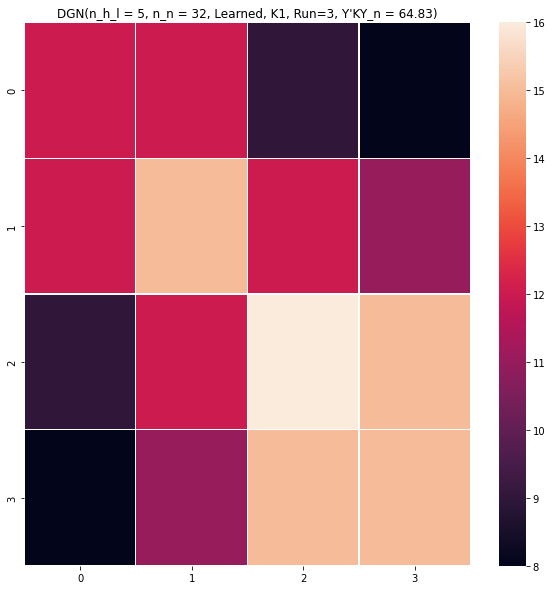

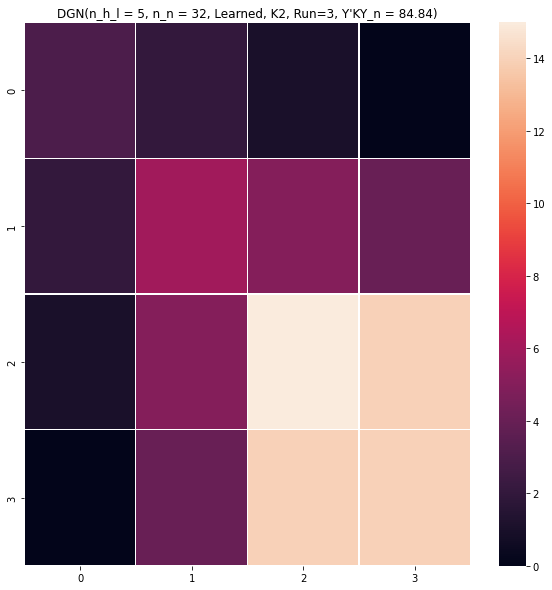

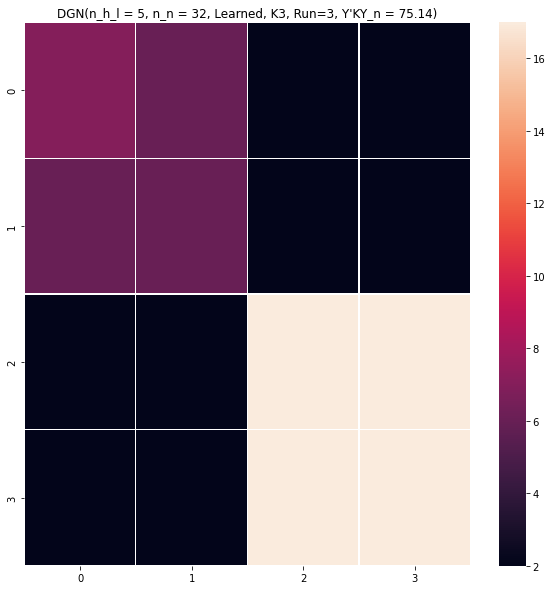

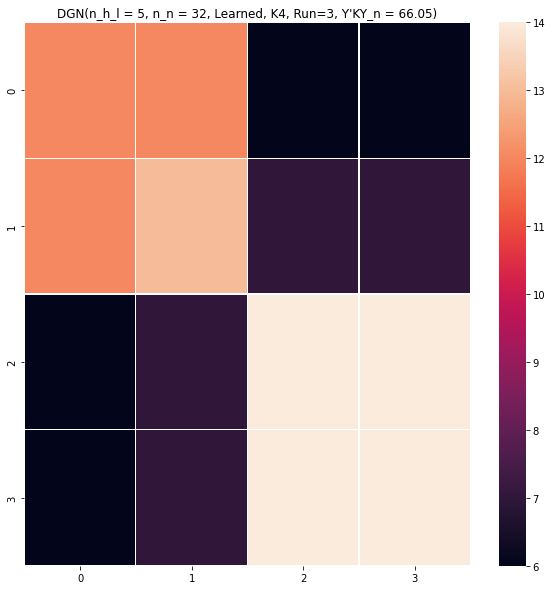

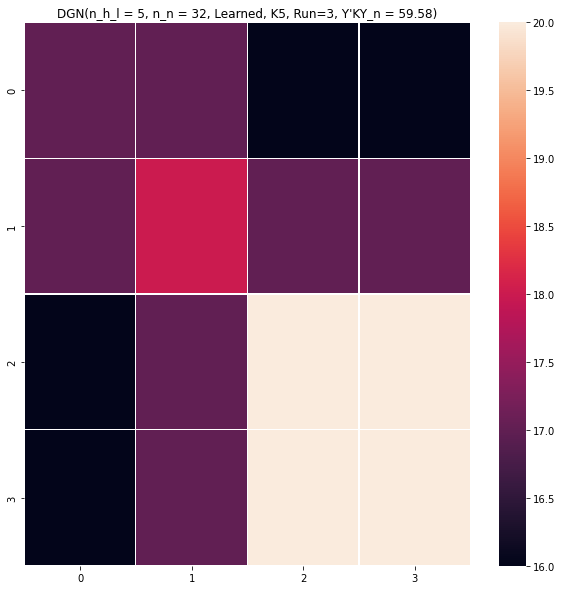

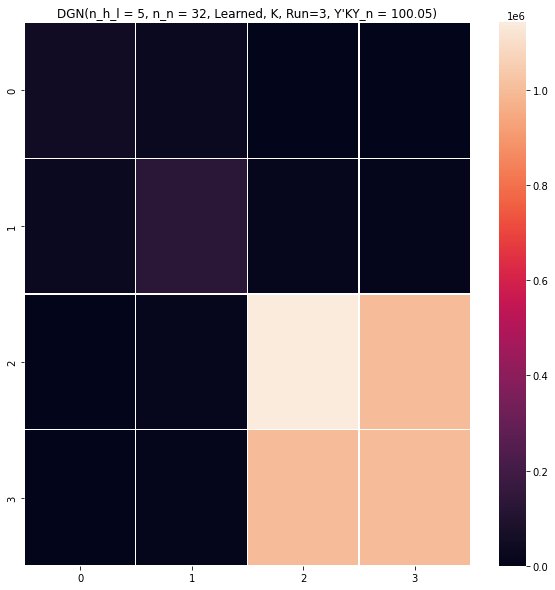

Test Error: 
 Avg loss: 0.589818 



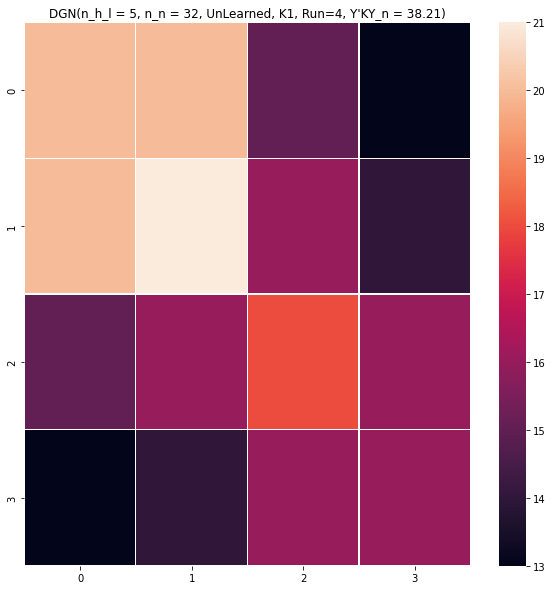

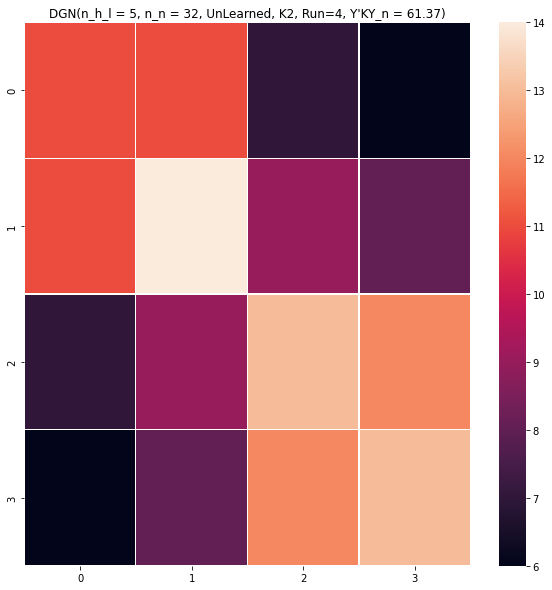

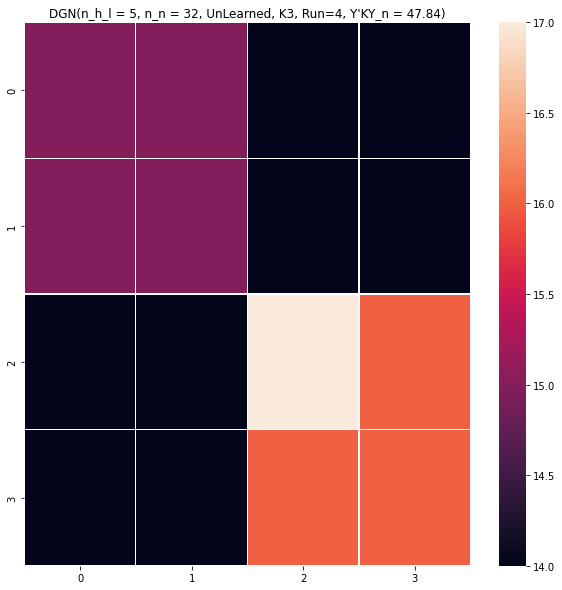

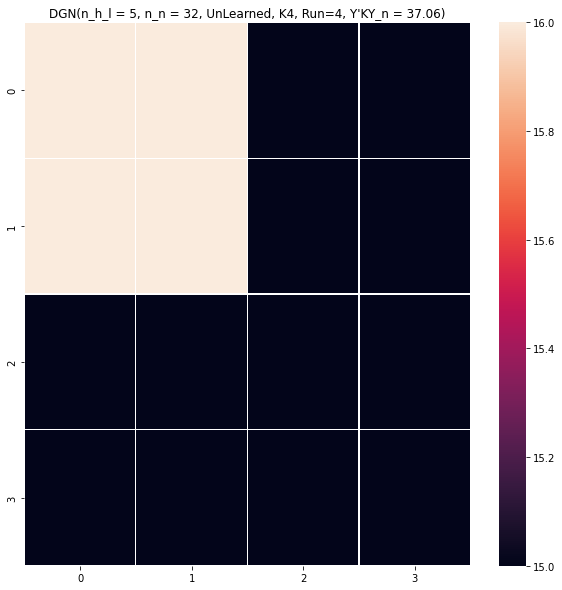

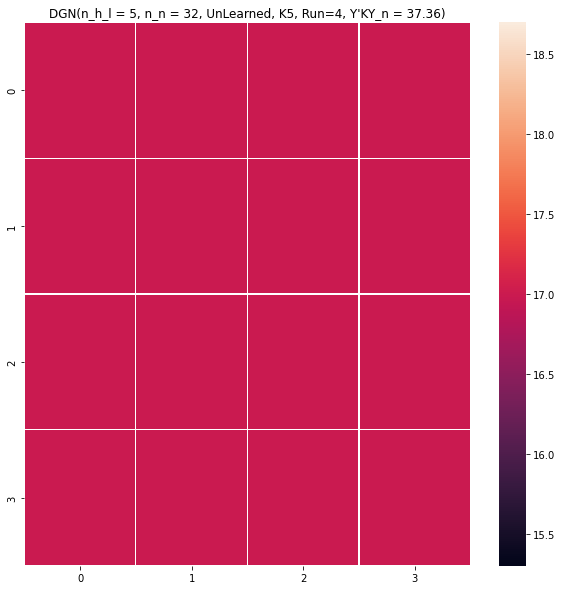

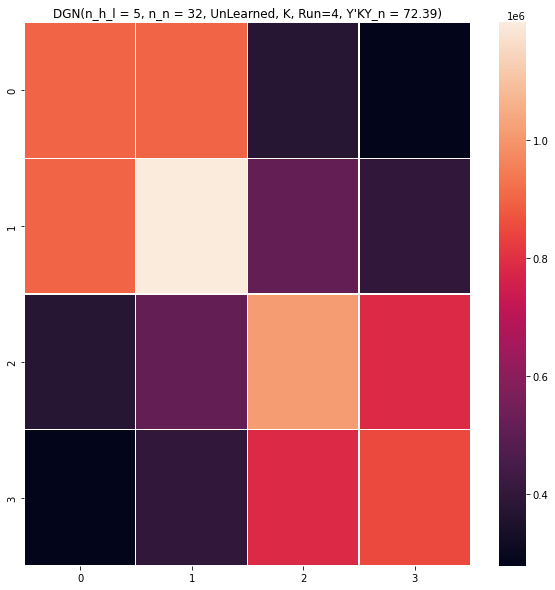

Epoch 1
-------------------------------
loss: 0.525996 Batch:0 [    0/  450]
loss: 0.540655 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.311358 

Test Error: 
 Avg loss: 0.415390 

Epoch 2
-------------------------------
loss: 0.567704 Batch:0 [    0/  450]
loss: 0.381725 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.250973 

Test Error: 
 Avg loss: 0.324231 

Epoch 3
-------------------------------
loss: 0.362006 Batch:0 [    0/  450]
loss: 0.262989 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.239304 

Test Error: 
 Avg loss: 0.276749 

Epoch 4
-------------------------------
loss: 0.225616 Batch:0 [    0/  450]
loss: 0.259074 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.246958 

Test Error: 
 Avg loss: 0.259187 

Epoch 5
-------------------------------
loss: 0.294594 Batch:0 [    0/  450]
loss: 0.140614 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.249738 

Test Error: 
 Avg loss: 0.255262 

Epoch 6
-------------------------------
loss: 0.331268 Batch:0 [    0/  450

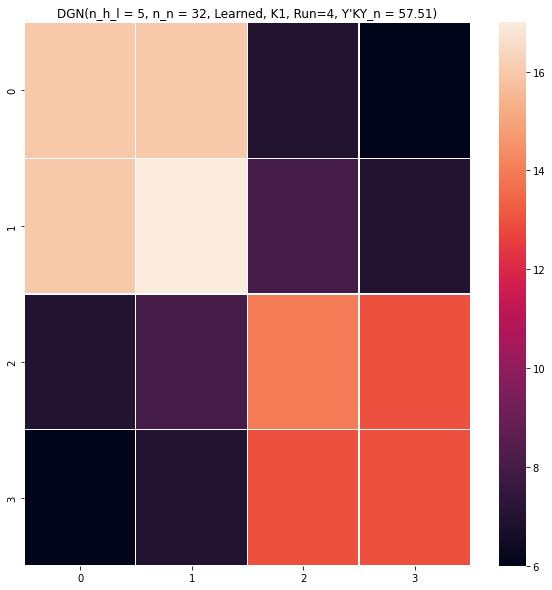

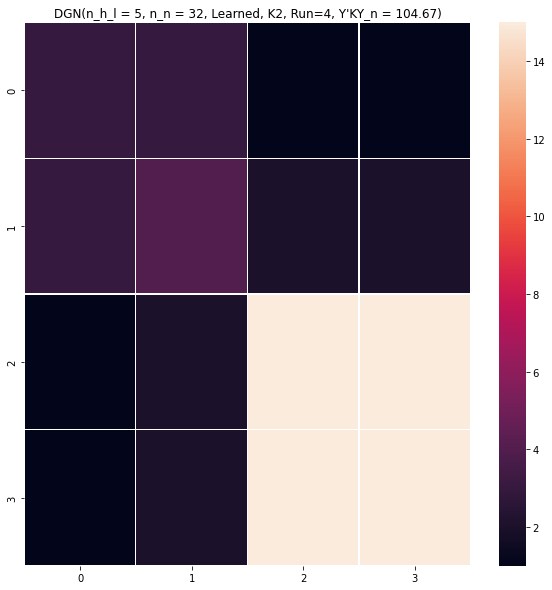

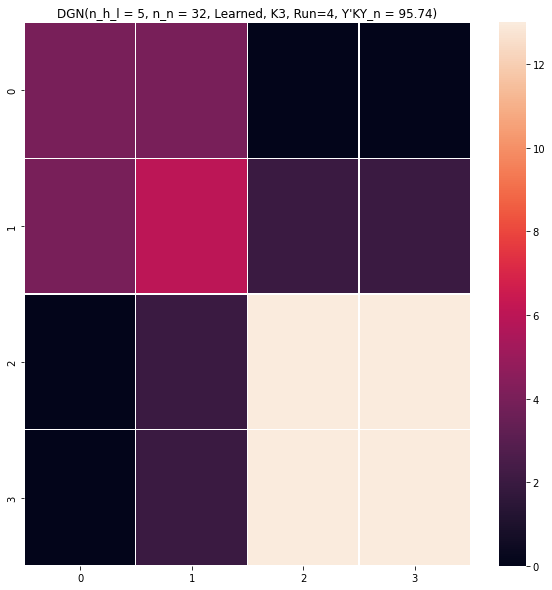

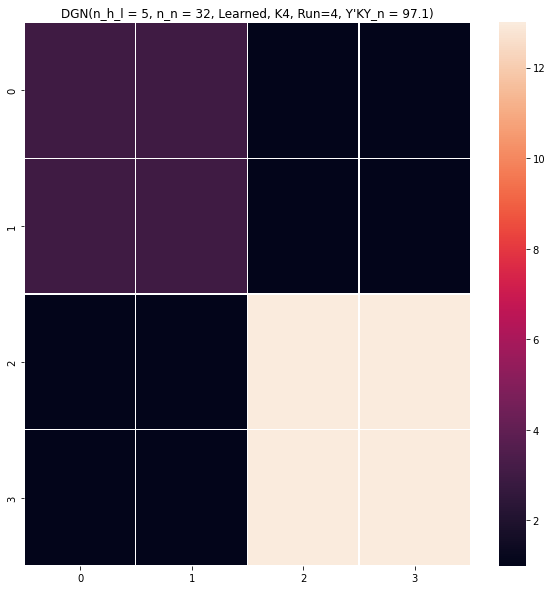

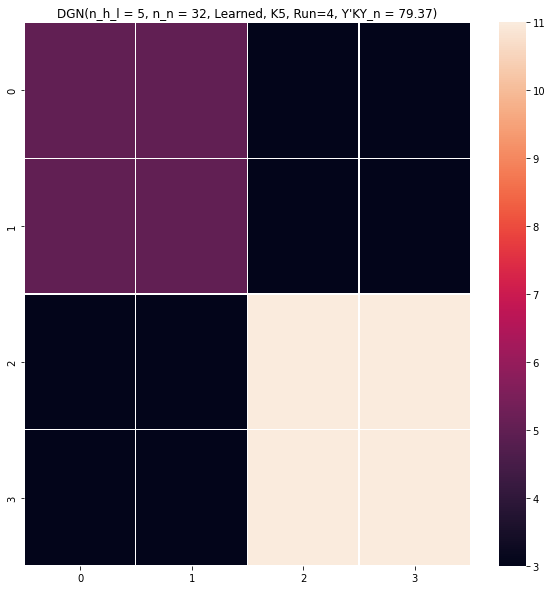

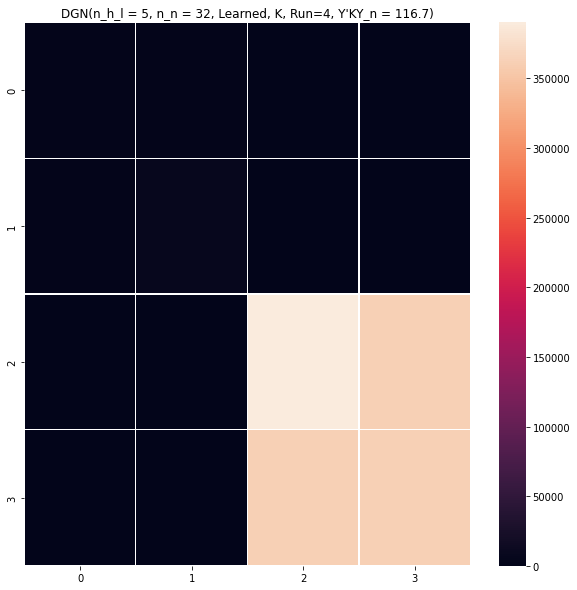

Test Error: 
 Avg loss: 0.543896 



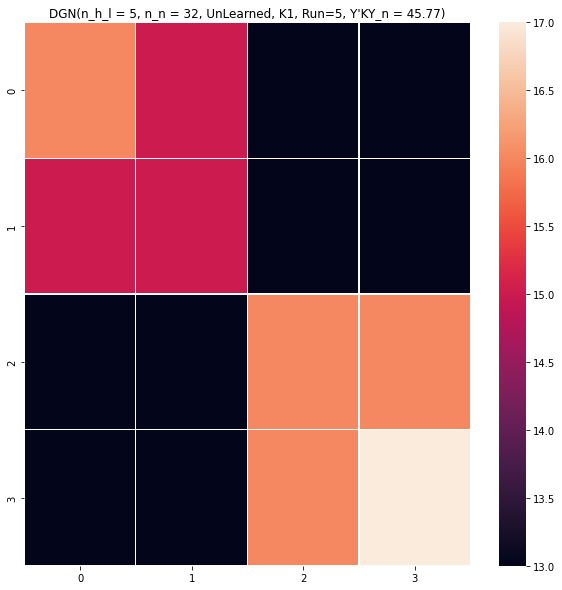

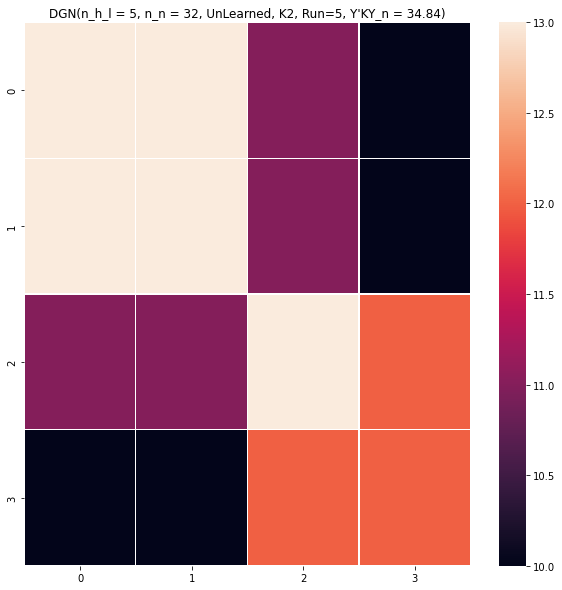

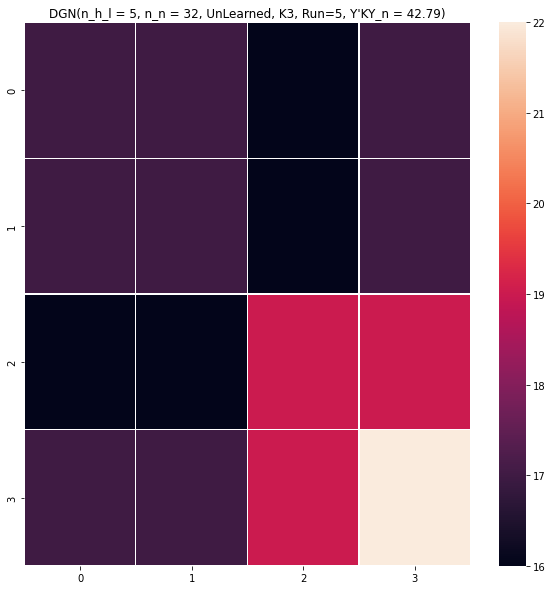

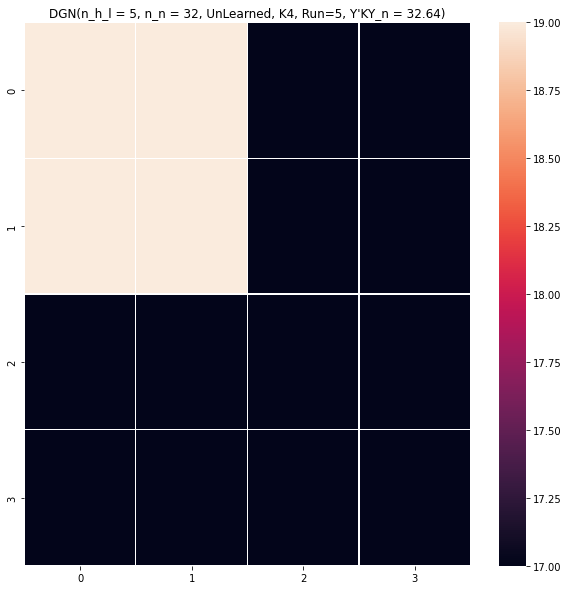

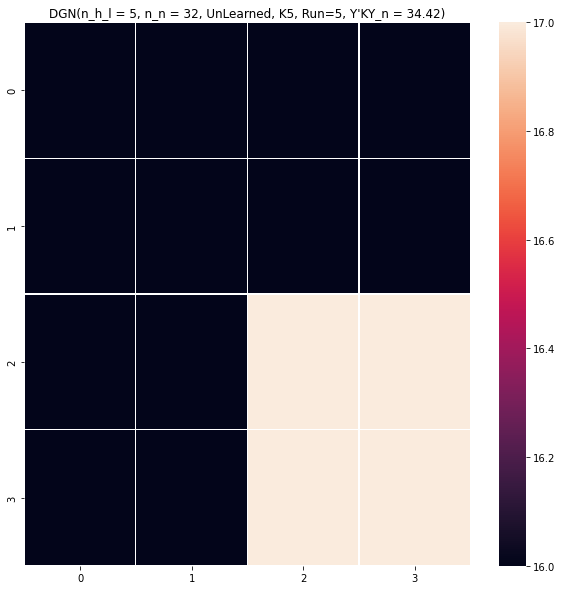

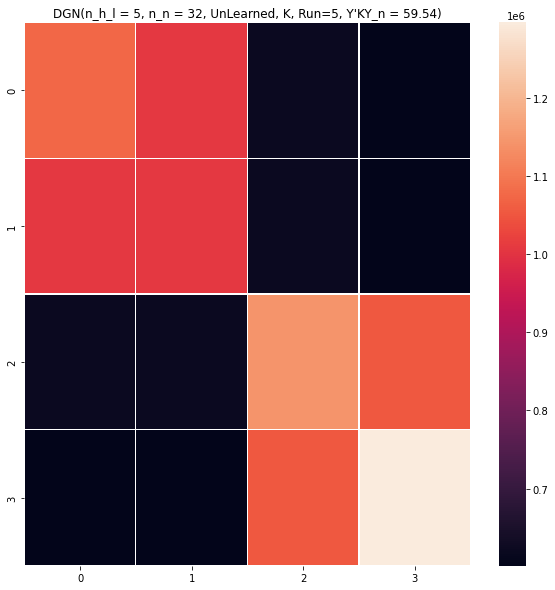

Epoch 1
-------------------------------
loss: 0.520118 Batch:0 [    0/  450]
loss: 0.461849 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.420879 

Test Error: 
 Avg loss: 0.391775 

Epoch 2
-------------------------------
loss: 0.353370 Batch:0 [    0/  450]
loss: 0.499750 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.244606 

Test Error: 
 Avg loss: 0.269193 

Epoch 3
-------------------------------
loss: 0.306568 Batch:0 [    0/  450]
loss: 0.195592 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.245226 

Test Error: 
 Avg loss: 0.243463 

Epoch 4
-------------------------------
loss: 0.234712 Batch:0 [    0/  450]
loss: 0.220371 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.209356 

Test Error: 
 Avg loss: 0.236071 

Epoch 5
-------------------------------
loss: 0.121734 Batch:0 [    0/  450]
loss: 0.162722 Batch:10 [  320/  450]
Test Error: 
 Avg loss: 0.198489 

Test Error: 
 Avg loss: 0.234472 

Epoch 6
-------------------------------
loss: 0.228025 Batch:0 [    0/  450

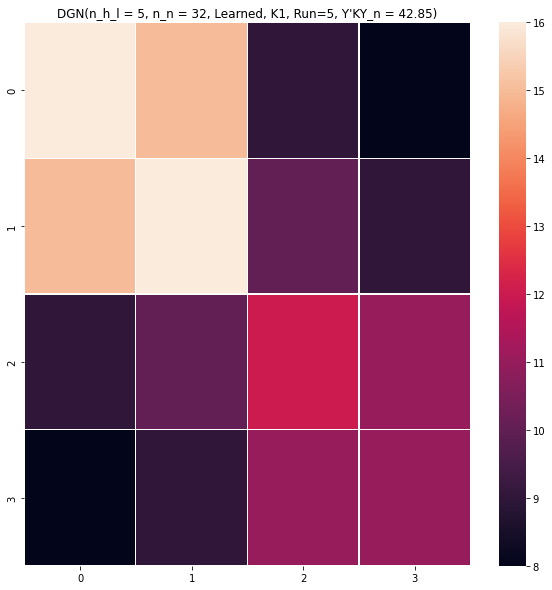

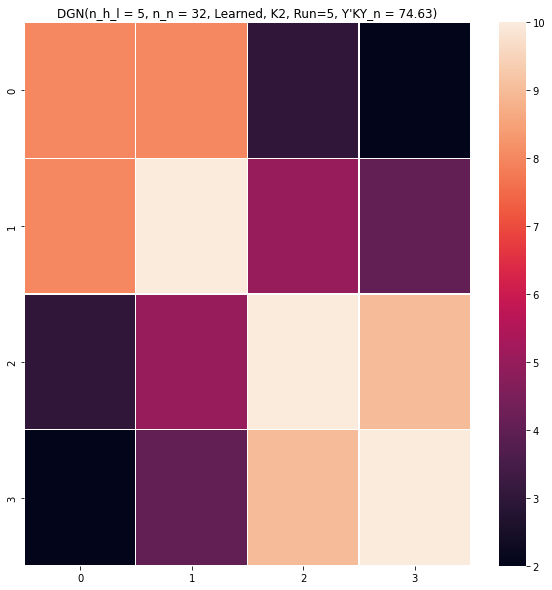

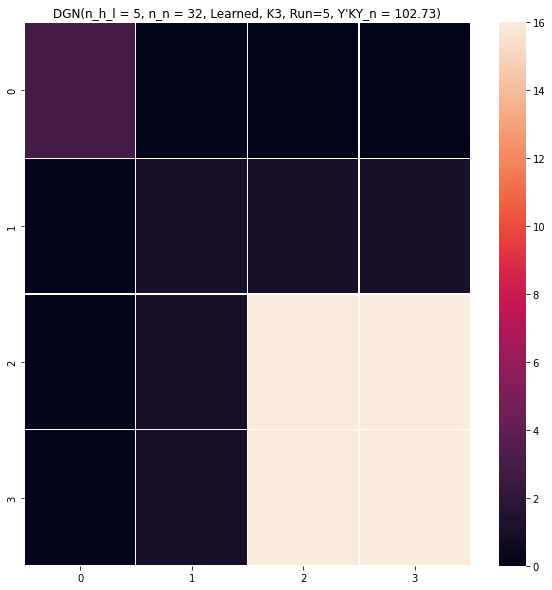

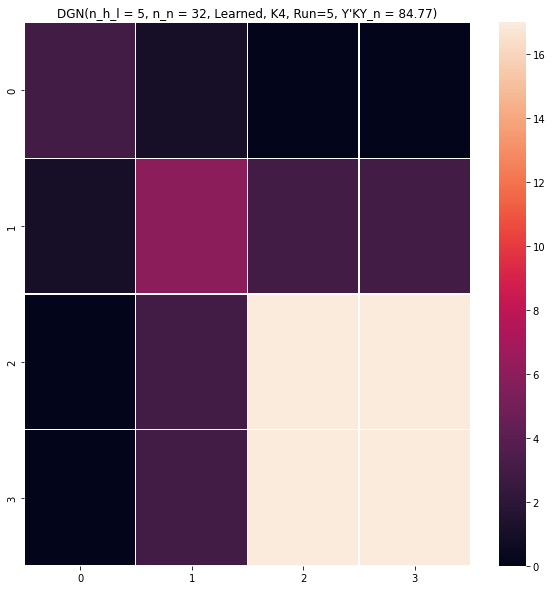

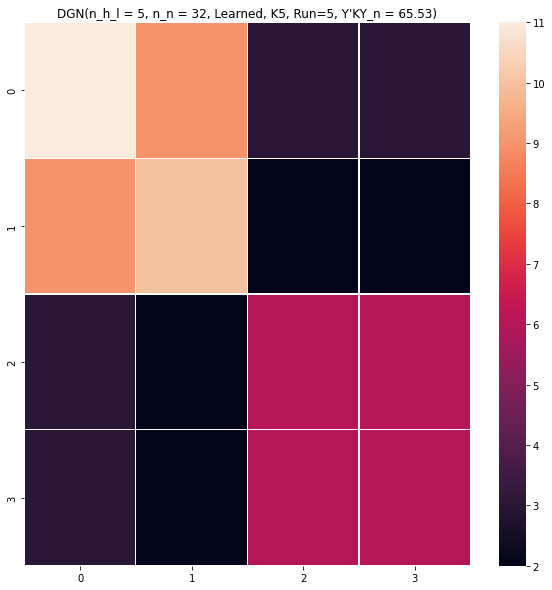

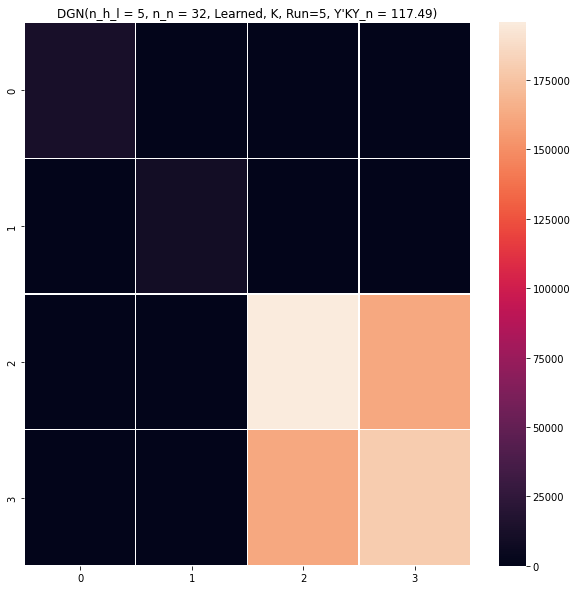

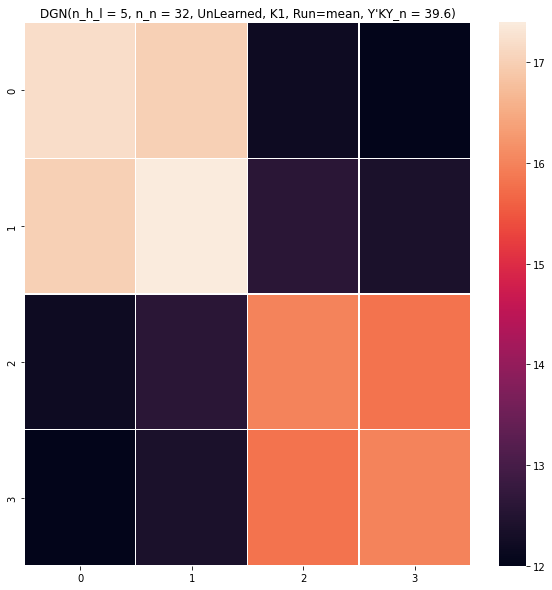

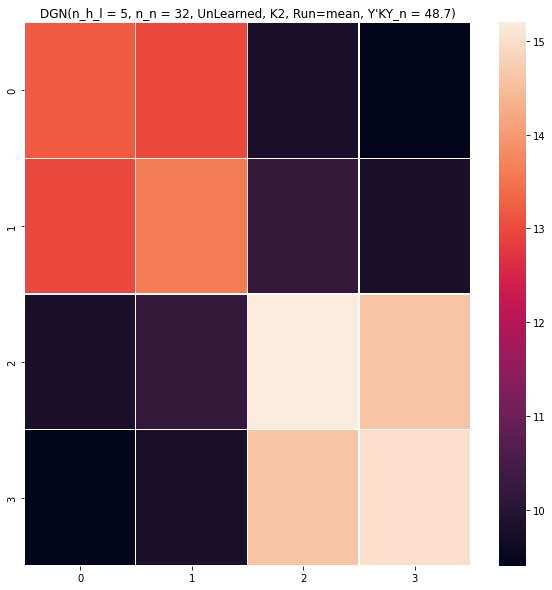

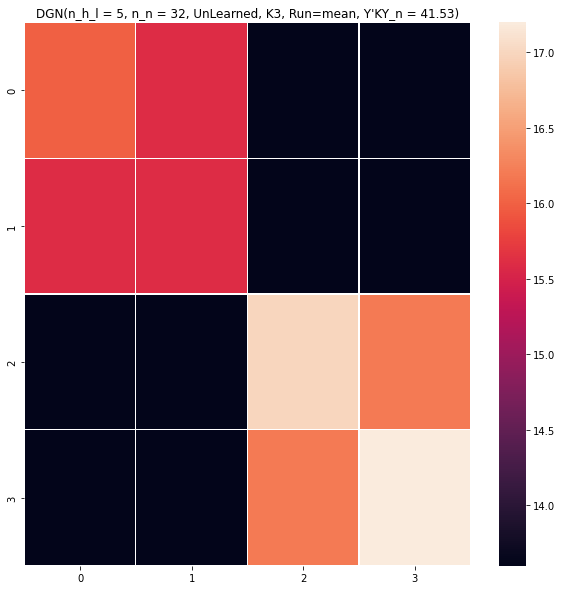

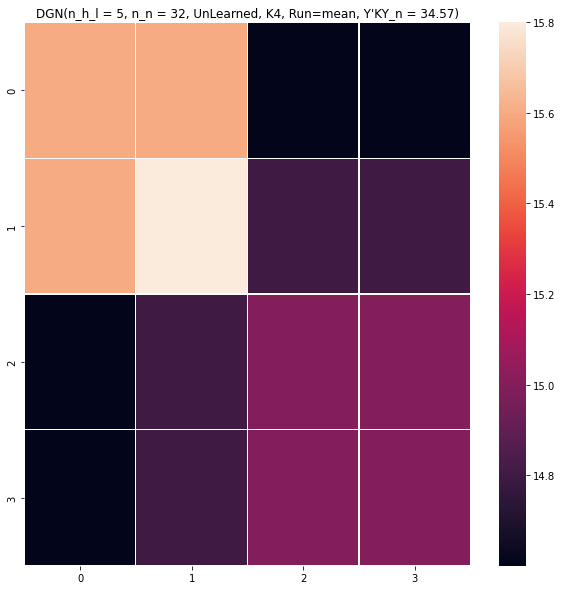

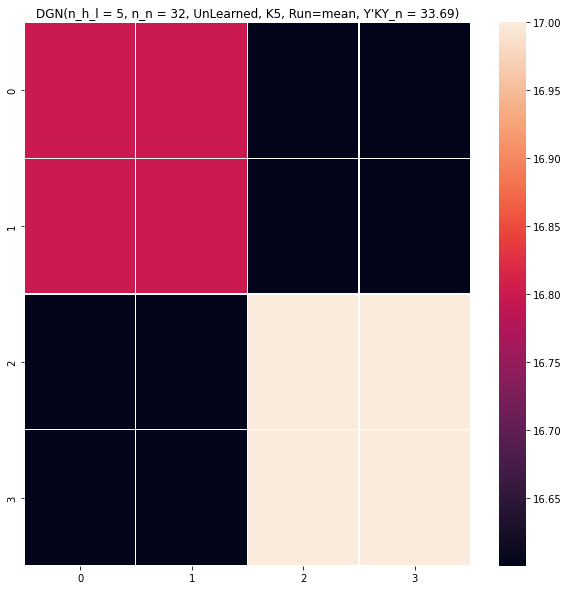

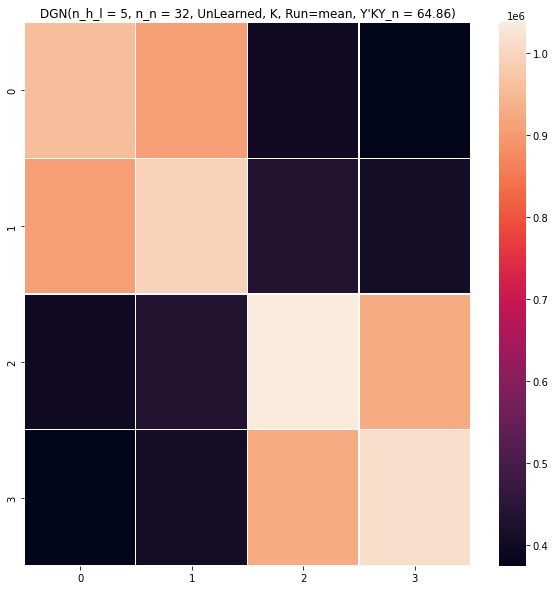

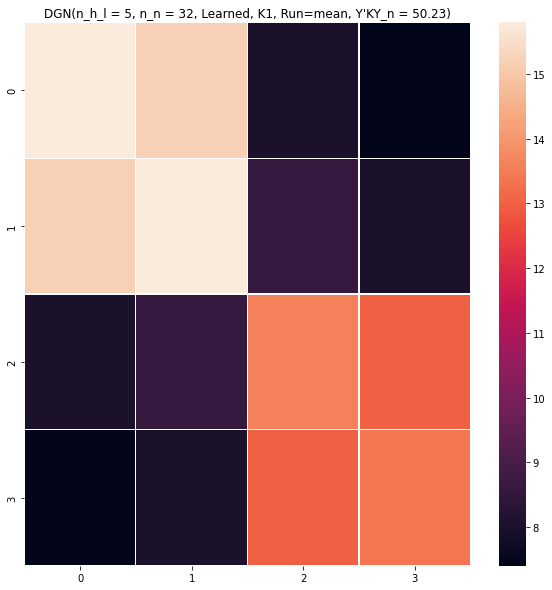

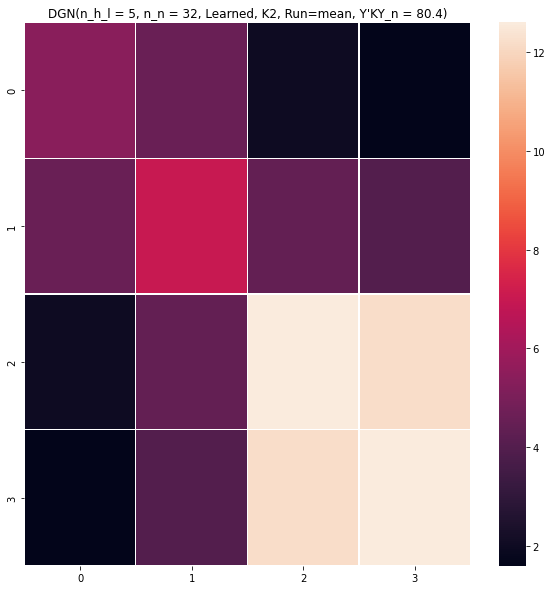

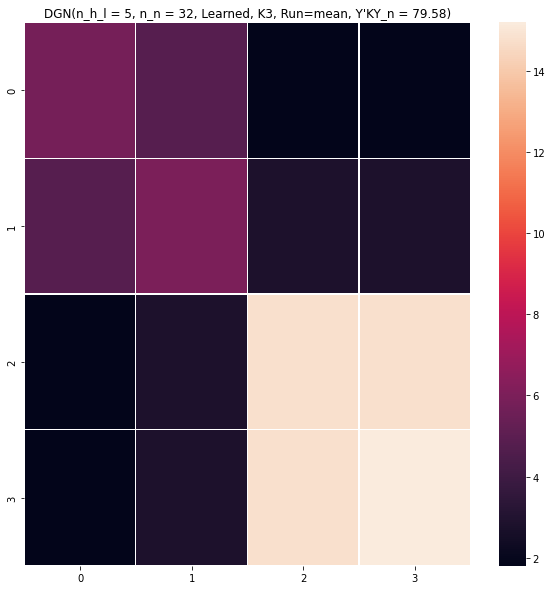

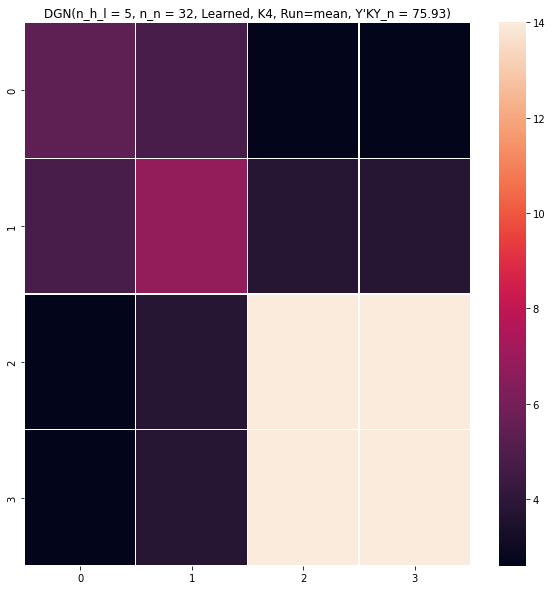

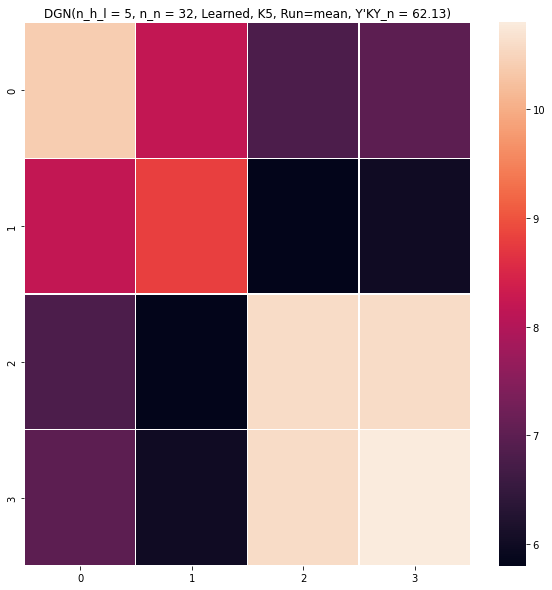

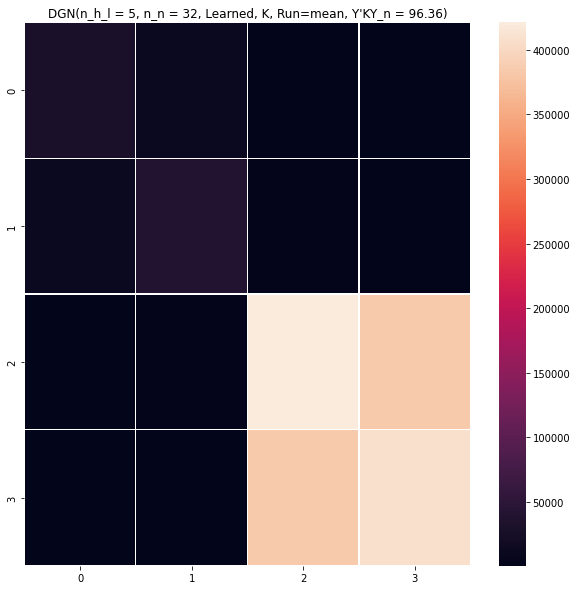

In [ ]:
all_intermediate_outs = []
info_list = []
for m_a in ['DGN']:
  model_architecture_type = m_a
  # model_info = {"model_architecture_type" : model_architecture_type,"n_hidden_layers":n_hidden_layers, "n_neurons" : n_neurons}

  for n_h_l in [ 5]:
    n_hidden_layers = n_h_l
    for n_n in [32]:
      n_neurons = n_n

      model_info = {"model_architecture_type" : model_architecture_type,"n_hidden_layers":n_hidden_layers, "n_neurons" : n_neurons}
      kernels_over_5 = []
      rand_kernels_over_5 = []
      
      for i in range(5):
        intermediate_outs = []
        model_info["Run"] = str(i+1)
        n_data_points = 500
        x1 = np.random.uniform(low = -1, high = 1, size = (n_data_points,1))
        x2 = np.random.uniform(low = -1, high = 1, size = (n_data_points,1))

        X = np.concatenate((x1, x2), axis = 1)
        X = X/np.sqrt(x1**2 + x2**2)

        Y = [ [np.sin(np.arcsin(i))] if i > 0 else [np.sin(10*np.arcsin(i))]  for i in X[:,1] ]
        Y = np.array(Y)

        n_data = len(Y)

        #plt.figure(figsize=(10,10))
        #plt.scatter(X[:,0], X[:,1], c = Y)
        #plt.savefig("Input Data")
        #sorted_arg = np.argsort(X[:, 0])
        sorted_arg = np.argsort(np.arctan2(X[:,1],X[:,0])*180/np.pi)
        X_sorted = X[sorted_arg]
        Y_sorted = Y[sorted_arg]

        batch_size = len(Y)
        dataloader = DataLoader(CustomDataset(X_sorted, Y_sorted), batch_size = batch_size, shuffle = False)
        
        batch_size = 32
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, shuffle = True)

        train_dataloader = DataLoader(CustomDataset(X_train, y_train), batch_size = batch_size, shuffle = True)
        test_dataloader = DataLoader(CustomDataset(X_test, y_test), batch_size = batch_size, shuffle = True)
        #----------------get index for 4 points out of which both the pairs are separated by 10 deg
        temp = np.array(np.sort(np.arctan2(X[:,1],X[:,0])*180/np.pi), dtype = int)
        value1 = -30
        x1_idx = find_nearest(temp, value1)
        x2_idx = find_nearest(temp, value1+10)

        value2 = 40
        x3_idx = find_nearest(temp, value2)
        x4_idx = find_nearest(temp, value2+10)
  #--------------


        npf_model = NPFNeuralNetwork(n_hidden_layers, n_neurons, model_architecture_type).to(device)
        npv_model = NPVNeuralNetwork(n_hidden_layers, n_neurons).to(device)
        model_learning_status = "UnLearned"

        loss_fn = nn.MSELoss()
        optimizer = torch.optim.Adam([
                        {'params': npf_model.parameters()},
                        {'params': npv_model.parameters()}],
                        lr = 3e-3) 
        
        #some_routine(rand_kernels_over_5)
        prediction, hidden_layer_outputs = test_decoupled(dataloader,npf_model, npv_model, loss_fn)

        #----
        intermediate_outs.append(np.array((hidden_layer_outputs[1][[x1_idx, x2_idx, x3_idx, x4_idx]]).detach().to('cpu')))
        #----

        kernels = get_kernels(hidden_layer_outputs)

        rand_kernels_over_5.append(kernels)
        YKYs = []
        for i in range(len(kernels)):
          YKY = np.matmul(np.matmul(Y_sorted.T, kernels[i]), Y_sorted)
          eigen_vals = eigh(kernels[i], eigvals_only = True)
          YKYs.append(str(round(YKY[0][0]/eigen_vals[-1], 2)))
          

        model_info["Y'KY"] = YKYs
        plot_heatmap(kernels, model_info)


        epochs = 250
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train_decoupled(train_dataloader,train_dataloader,npf_model, npv_model, loss_fn, optimizer)
            test_decoupled(test_dataloader,npf_model, npv_model, loss_fn)
            #----
            prediction, hidden_layer_outputs = test_decoupled(dataloader,npf_model, npv_model, loss_fn)
            intermediate_outs.append(np.array((hidden_layer_outputs[1][[x1_idx, x2_idx, x3_idx, x4_idx]]).detach().to('cpu')))
            #----
            
        print("Done!")
        all_intermediate_outs.append(intermediate_outs)#--------


        model_learning_status = "Learned"
  
        #some_routine() code
        '''
        some_routine(kernels_over_5)
        '''
        prediction, hidden_layer_outputs = test_decoupled(dataloader,npf_model, npv_model, loss_fn)
        kernels = get_kernels(hidden_layer_outputs)
        kernels_over_5.append(kernels)
        YKYs = []
        for i in range(len(kernels)):
          YKY = np.matmul(np.matmul(Y_sorted.T, kernels[i]), Y_sorted)
          eigen_vals = eigh(kernels[i], eigvals_only = True)
          YKYs.append(str(round(YKY[0][0]/eigen_vals[-1], 2)))
          

        model_info["Y'KY"] = YKYs
        plot_heatmap(kernels, model_info)
        
        


      kernels_mean = np.mean(np.array(rand_kernels_over_5), axis = 0)
      YKYs = []
      for i in range(len(kernels_mean)):
        YKY = np.matmul(np.matmul(Y_sorted.T, kernels_mean[i]), Y_sorted)
        eigen_vals = eigh(kernels_mean[i], eigvals_only = True)
        YKYs.append(str(round(YKY[0][0]/eigen_vals[-1], 2)))
      
      model_learning_status = "UnLearned"
      model_info["Y'KY"] = YKYs
      model_info["Run"] = "mean"
      model_info["model_learning_status"] = "UnLearned"
      info_list.append(list(model_info.values()).copy())
      plot_heatmap(kernels_mean, model_info)
    
    



      kernels_mean = np.mean(np.array(kernels_over_5), axis = 0)
      YKYs = []
      for i in range(len(kernels_mean)):
        YKY = np.matmul(np.matmul(Y_sorted.T, kernels_mean[i]), Y_sorted)
        eigen_vals = eigh(kernels_mean[i], eigvals_only = True)
        YKYs.append(str(round(YKY[0][0]/eigen_vals[-1], 2)))
      model_learning_status = "Learned"
      model_info["Y'KY"] = YKYs
      model_info["Run"] = "mean"
      model_info["model_learning_status"] = "Learned"
      info_list.append(list(model_info.values()).copy())
      plot_heatmap(kernels_mean, model_info)
      # print(model_info.values())
      





      

      '''
      YKY = np.matmul(np.matmul(Y_sorted.T, kernels_mean[-1]), Y_sorted)
      eigen_vals = eigh(kernels_mean[-1], eigvals_only = True)
      model_info["Y'KY"] = str(round(YKY[0][0]/eigen_vals[-1], 2))
      model_info["Run"] = "mean"
      plot_heatmap(kernels_mean, model_info)
      '''

In [ ]:
len(info_list)

6

In [ ]:
output = pd.DataFrame(info_list)


In [ ]:
output = pd.DataFrame(info_list)
sub_out = pd.DataFrame(list(output[4]))

sub_out = sub_out.fillna(value='Null')
cols = sub_out.ne('Null').cumsum(axis=1).idxmax(axis=1)
K_temp = sub_out.lookup(sub_out.index, cols)

cols = list(cols)

for i, row in sub_out.iterrows():
  sub_out.at[i,cols[i]] = 'Null'
sub_out.insert(0, 'K', K_temp)

final_sub_out = sub_out
final_output = pd.concat([output, final_sub_out], axis = 1, ignore_index=True)


In [ ]:
final_output

In [ ]:
# final_output = final_output.drop([4,7, final_output.shape[1]-1], 1)
# final_output

In [ ]:
# final_output = final_output.set_axis(['Architecture', 'n_h_l', 'n_n','Run', 'Status', 'K'], axis=1, inplace=False)

In [ ]:
final_output = final_output.drop([4, final_output.shape[1]-1], 1)
final_output

In [ ]:
#final_output = final_output.drop([4, -1], 1)
# final_output = final_output.set_axis(['Architecture', 'n_h_l', 'n_n','Run', 'Status', 'K', 'K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8'], axis=1, inplace=False)
final_output = final_output.set_axis(['Architecture', 'n_h_l', 'n_n','Run', 'Status', 'K', 'K1', 'K2', 'K3', 'K4', 'K5'], axis=1, inplace=False)

In [ ]:
final_output

In [ ]:
final_output.to_csv('final_output.csv')
files.download("final_output.csv")


In [ ]:
files.download("latest_run2_5128.zip")


In [ ]:
plot_heatmap(kernels_mean, model_info)


In [ ]:
#npf_model.load_state_dict(model.state_dict())
#npv_model.load_state_dict(npk_model.state_dict())

In [ ]:
'''
for param in npf_model.parameters():
  param.requires_grad = True
'''

'\nfor param in npf_model.parameters():\n  param.requires_grad = True\n'

In [ ]:
import os
DIR = "/content"

# if you want to list all the contents in DIR
entries = [entry for entry in os.listdir(DIR)]

In [ ]:
# p, _ = npv_model(torch.tensor(np.random.rand(32,2)).float().to(device), npf_model(torch.tensor(np.random.rand(32,2)).float().to(device)))
# make_dot(p)

In [ ]:
len(entries)

596

In [ ]:
len(entries)

596

In [ ]:
files.download("myfiles.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
dF1 = pd.read_csv("final_output1.csv")
dF2 = pd.read_csv("final_output2.csv")
dF3 = pd.read_csv("final_output3.csv")
dF4 = pd.read_csv("final_output4.csv")
dF5 = pd.read_csv("final_output5.csv")
dF6 = pd.read_csv("final_output6.csv")

In [ ]:
sin10_all_out = pd.concat([dF6, dF1,dF3, dF4,dF5, dF2], axis=0).drop(['Unnamed: 0'], axis = 1)

In [ ]:
dF7 = pd.read_csv("final_output7.csv")
dF8 = pd.read_csv("final_output8.csv")

In [ ]:
sin4_all_out = pd.concat([dF7, dF8], axis=0).drop(['Unnamed: 0'], axis = 1)

In [ ]:
sin10_all_out.to_csv('sin10_all_output.csv')
sin4_all_out.to_csv('sin4_all_output.csv')

In [ ]:
n = 6
for entry in entries:
    #files.download(entry)
    print(entry)

.config
final_output2.csv
final_output5.csv
final_output1.csv
final_output4.csv
final_output3.csv
final_output6.csv


**DLGN-SF(Shallow Features)**


In [ ]:

n_hidden_layers = 3
n_neurons = 32
model_architecture_type = "DLGN-SF"
model_info = {"model_architecture_type" : model_architecture_type,"n_hidden_layers":n_hidden_layers, "n_neurons" : n_neurons}

npf_model = NPFNeuralNetwork(n_hidden_layers, n_neurons, model_architecture_type).to(device)
npv_model = NPVNeuralNetwork(n_hidden_layers, n_neurons).to(device)
model_learning_status = "UnLearned"


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam([
                {'params': npf_model.parameters()},
                {'params': npv_model.parameters()}],
                lr = 3e-3) 


epochs = 300

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_decoupled(train_dataloader,train_dataloader,npf_model, npv_model, loss_fn, optimizer)
    test_decoupled(test_dataloader,npf_model, npv_model, loss_fn)
    
print("Done!")
model_learning_status = "Learned"


prediction, hidden_layer_outputs = test_decoupled(dataloader,npf_model, npv_model, loss_fn)

#plot_heatmap(kernels,model_info)

In [ ]:
def  get_hyperplanes_params(model, for_layers):
  layer_weights = []
  layer_slopes = []
  layer_intercepts = []
  for i in range(for_layers):
    layer_weight = model.layers[i].weight.detach().to("cpu")
    layer_slope = -(layer_weight[:,0]/layer_weight[:,1])
    layer_intercept = [0]*32#model.layers[i].bias.detach().to("cpu")

    layer_weights.append(layer_weight)
    layer_slopes.append(layer_slope)
    layer_intercepts.append(layer_intercept)
  return layer_slopes, layer_intercepts


def plot_hyperplanes(model, train_status):
  
  for_layers = len(model.layers)-1
  layer_slopes, layer_intercepts = get_hyperplanes_params(model, for_layers)
  
  
  x_axis = np.linspace(start = -2, stop = 2)
  for i in range(for_layers):
    plt.figure(figsize = (10,10))
    #fig, ax = plt.subplots(figsize = (10,10))
    ax = sns.scatterplot(X_sorted[:,0], X_sorted[:,1], c = prediction.to("cpu"))
    ax.set_xlim((-2,2))
    ax.set_ylim((-2,2))
    for j in range(32):
      y_axis = layer_slopes[i][j]*x_axis + layer_intercepts[i][j]
      #plt.plot(x_axis, y_axis)
      sns.lineplot(x = x_axis, y = y_axis)
    plt.title(train_status+" Layer_"+str(i+1))
    plt.savefig(train_status+" Layer_"+str(i+1))
    plt.show()

In [ ]:
npf_model

NPFNeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=False)
    (1): Linear(in_features=2, out_features=32, bias=False)
    (2): Linear(in_features=2, out_features=32, bias=False)
    (3): Linear(in_features=32, out_features=1, bias=False)
  )
)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


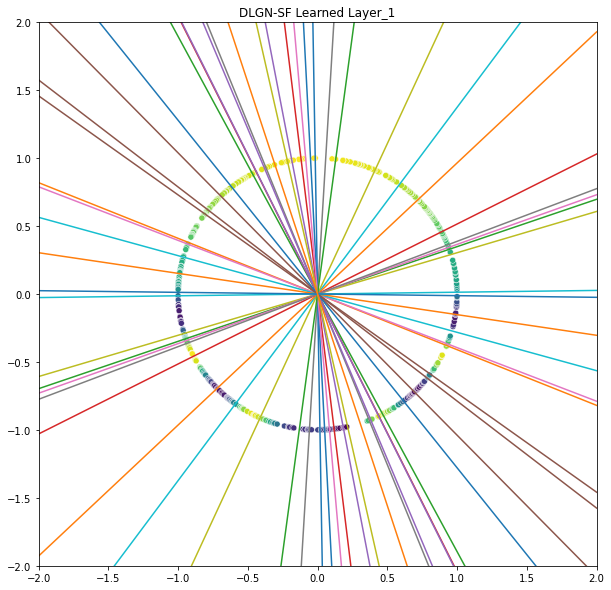

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


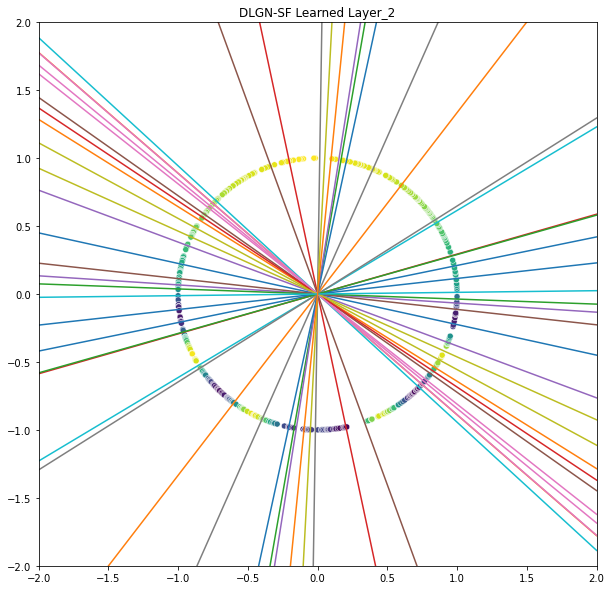

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


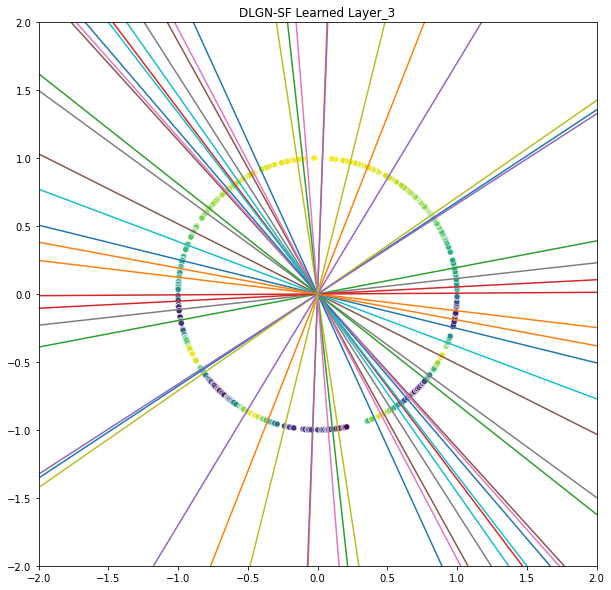

In [ ]:
plot_hyperplanes(npf_model, model_architecture_type+" "+model_learning_status)

In [ ]:
plot_hyperplanes(npf_model, model_architecture_type+" "+model_learning_status)

In [ ]:
plot_hyperplanes([npf_model], model_architecture_type+" "+model_learning_status)

In [ ]:
plot_hyperplanes([npf_model], model_architecture_type+" "+model_learning_status)